# Predicción acerca de ¿qué cultivo es óptimo para implantar  en una determina región?

### Objetivos

- Realizar un modelo predictivo basado en algoritmos de aprendizaje supervisado de clasificación multiclase que permitan conocer el cultivo más adecuado a implantar de acuerdo a las características medioambientales y físico-químicas del suelo de una región en particular.
- Realizar un modelo predictivo basado en algoritmos de aprendizaje no supervisado de clustering para buscar patrones. 
- El rendimiento de la predicción se medirá a partir del Acurracy y el F1 (macro) .

#### Importación de librerías 

In [124]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np

from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib_inline
import matplotlib.image as mpimg
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from IPython.display import Image 
from pprint import pprint ## To plot trees

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

#preprocessing libraries
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler, MinMaxScaler, LabelBinarizer, QuantileTransformer, Binarizer 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, KFold, RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_absolute_error, mean_squared_error, r2_score, f1_score, make_scorer
from sklearn.pipeline import Pipeline, make_pipeline

from scipy import stats
from scipy.stats import shapiro

from imblearn.pipeline import Pipeline

#### Se realizará la carga del data set

In [2]:
ds = pd.read_csv('Crop_recommendation.csv', sep=',')
df = pd.DataFrame(ds)
df

N   P   K  temperature   humidity        ph    rainfall   label
0      90  42  43    20.879744  82.002744  6.502985  202.935536    rice
1      85  58  41    21.770462  80.319644  7.038096  226.655537    rice
2      60  55  44    23.004459  82.320763  7.840207  263.964248    rice
3      74  35  40    26.491096  80.158363  6.980401  242.864034    rice
4      78  42  42    20.130175  81.604873  7.628473  262.717340    rice
...   ...  ..  ..          ...        ...       ...         ...     ...
2195  107  34  32    26.774637  66.413269  6.780064  177.774507  coffee
2196   99  15  27    27.417112  56.636362  6.086922  127.924610  coffee
2197  118  33  30    24.131797  67.225123  6.362608  173.322839  coffee
2198  117  32  34    26.272418  52.127394  6.758793  127.175293  coffee
2199  104  18  30    23.603016  60.396475  6.779833  140.937041  coffee

[2200 rows x 8 columns]

### Descripción de la base de datos

- Estos datos han sido extraídos de la página web de **Kaggle**.
- La base de datos contiene 2200 registros correspondientes a factores medioambientales y factores físico-químico del suelo. Dichos registros forman parte del ciclo productivo de cultivos implantados en India.

#### Se procederá a renombrar cada columna. 

In [3]:
df.columns = ['Nitrogeno(N)', 'Fosforo(P)', 'Potasio(K)', 'Temperatura', 'Humedad', 'PH', 'Precipitacion', 'Cultivo']
df

Nitrogeno(N)  Fosforo(P)  Potasio(K)  Temperatura    Humedad        PH  \
0               90          42          43    20.879744  82.002744  6.502985   
1               85          58          41    21.770462  80.319644  7.038096   
2               60          55          44    23.004459  82.320763  7.840207   
3               74          35          40    26.491096  80.158363  6.980401   
4               78          42          42    20.130175  81.604873  7.628473   
...            ...         ...         ...          ...        ...       ...   
2195           107          34          32    26.774637  66.413269  6.780064   
2196            99          15          27    27.417112  56.636362  6.086922   
2197           118          33          30    24.131797  67.225123  6.362608   
2198           117          32          34    26.272418  52.127394  6.758793   
2199           104          18          30    23.603016  60.396475  6.779833   

      Precipitacion Cultivo  
0        202.935536    rice  
1        226.655537    rice  
2        263.964248    rice  
3        242.864034    rice  
4        262.717340    rice  
...             ...     ...  
2195     177.774507  coffee  
2196     127.924610  coffee  
2197     173.322839  coffee  
2198     127.175293  coffee  
2199     140.937041  coffee  

[2200 rows x 8 columns]

### Descripción de las variables

**El data set cuenta 8 columnas:**

**Features**
1. Nitrógeno(N): contenido de nitrógeno en el suelo en kg/ha.
2. Fósforo(P): contenido de fósforo en el suelo en kg/ha.
3. Potasio(K): contenido de potasio en el suelo en kg/ha.
4. Temperatura: temperatura en grados Celsius (°C).
5. Humedad: humedad relativa en %.
6. PH: valor de pH del suelo.
7. Precipitaciones: precipitaciones en mm.

**Target**: 

8. Cultivo: nombre del cultivo (variable target). 

#### Variable Cultivo (target)
- Se observa que en la variable target ("Cultivo")  hay 100 registros de cada clase.  


In [4]:
df.value_counts('Cultivo')

Cultivo
apple          100
banana         100
rice           100
pomegranate    100
pigeonpeas     100
papaya         100
orange         100
muskmelon      100
mungbean       100
mothbeans      100
mango          100
maize          100
lentil         100
kidneybeans    100
jute           100
grapes         100
cotton         100
coffee         100
coconut        100
chickpea       100
blackgram      100
watermelon     100
dtype: int64

## Exploración, análisis y visualización de los datos

<AxesSubplot:title={'center':'Cantidad de cultivos por clase'}, xlabel='Cultivo', ylabel='count'>

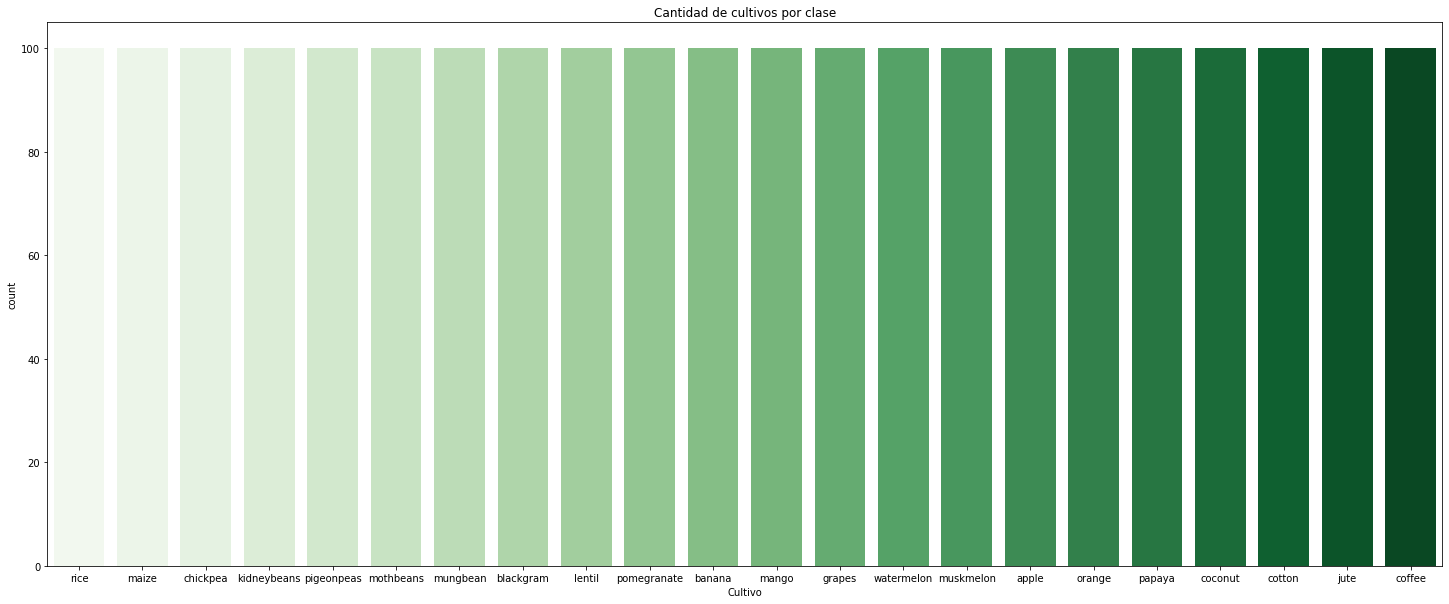

In [5]:
plt.figure(figsize=(25, 10))
plt.title("Cantidad de cultivos por clase")
sns.countplot(data=df, x= 'Cultivo', palette='Greens')

#### Nombre de las clases 
- Dentro de la variable "Cultivo" encontramos 22 clases distintas: 
1. Manzana (apple) 
2. Plátano (banana) 
3. Arroz (rice)
4. Granada (pomegranate)
5. Frijol/ Poroto Cajanus Caján (pigeonpeas)
6. Papaya (papaya)
7. Naranja (orange)
8. Melón (muskmelon)
9. Judía Mungo/ Soja verde (mungbean)
10. Frijol/ Poroto polilla (mothbeans)
11. Mango (mango)
12. Maíz (maize)
13. Lenteja (lentil)
14. Frijol riñon/ Poroto colorado (kidneybeans)
15. Yute (jute)
16. Uvas (grapes)
17. Algodón (cotton)
18. Café (coffee)
19. Coco (coconut)
20. Garbanzo (chickpea)
21. Frijol negro/ Poroto Mung (blackgram)
22. Sandía (watermelon)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Nitrogeno(N)   2200 non-null   int64  
 1   Fosforo(P)     2200 non-null   int64  
 2   Potasio(K)     2200 non-null   int64  
 3   Temperatura    2200 non-null   float64
 4   Humedad        2200 non-null   float64
 5   PH             2200 non-null   float64
 6   Precipitacion  2200 non-null   float64
 7   Cultivo        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


- No se encuentran valores nulos, ni valores NaN. 
- Cada columna tiene el tipo de datos que corresponde naturalmente. 

In [7]:
df.shape

(2200, 8)

In [8]:
df.ndim

2

In [9]:
df[['Temperatura', 'Humedad', 'PH', 'Precipitacion']] = df[['Temperatura', 'Humedad', 'PH', 'Precipitacion']].apply(lambda x: round(x, 6))

In [10]:
def estadisticos_cont(num):
    #Calculamos describe
    estadisticos = num.describe().T
    #Añadimos la mediana
    estadisticos['median'] = num.median()
    #Reordenamos para que la mediana esté al lado de la media
    estadisticos = estadisticos.iloc[:,[0,1,8,2,3,4,5,6,7]]
    #Lo devolvemos
    return(estadisticos)

In [11]:
estadisticos_cont(df.select_dtypes('number'))

count        mean     median        std        min        25%  \
Nitrogeno(N)   2200.0   50.551818  37.000000  36.917334   0.000000  21.000000   
Fosforo(P)     2200.0   53.362727  51.000000  32.985883   5.000000  28.000000   
Potasio(K)     2200.0   48.149091  32.000000  50.647931   5.000000  20.000000   
Temperatura    2200.0   25.616244  25.598693   5.063749   8.825675  22.769374   
Humedad        2200.0   71.481779  80.473145  22.263812  14.258040  60.261953   
PH             2200.0    6.469480   6.425045   0.773938   3.504752   5.971693   
Precipitacion  2200.0  103.463655  94.867625  54.958389  20.211267  64.551686   

                     50%         75%         max  
Nitrogeno(N)   37.000000   84.250000  140.000000  
Fosforo(P)     51.000000   68.000000  145.000000  
Potasio(K)     32.000000   49.000000  205.000000  
Temperatura    25.598693   28.561654   43.675493  
Humedad        80.473145   89.948770   99.981876  
PH              6.425045    6.923642    9.935091  
Precipitacion  94.867625  124.267508  298.560118

- Analizando las estadísticas descriptivas de todos las columnas con valores numéricos(media, mediana, máx, mín, std y count), se puede observar que no hay valores extraños en el dataset, excepto que el mínimo de nitrógeno es cero(0).
- Se procederá a ver que es lo que sucede.

In [183]:
df.value_counts(df['Nitrogeno(N)'] == 0.000000)

Nitrogeno(N)
False    2173
True       27
dtype: int64

In [180]:
# Filtrar el dataframe para mostrar solo las filas donde el valor de Nitrogeno(N) es igual a cero
filtro_nitrogeno = df['Nitrogeno(N)'] == 0.000000
df_filtrado = df[filtro_nitrogeno]

# Contar la frecuencia de cada valor único en la columna de Cultivo del dataframe filtrado
frecuencia_cultivos = df_filtrado['Cultivo'].value_counts()

# Mostrar los resultados
print(frecuencia_cultivos)


coconut        4
orange         4
lentil         4
apple          3
pomegranate    3
mango          3
kidneybeans    2
mungbean       1
pigeonpeas     1
grapes         1
mothbeans      1
rice           0
papaya         0
muskmelon      0
maize          0
banana         0
jute           0
cotton         0
coffee         0
chickpea       0
blackgram      0
watermelon     0
Name: Cultivo, dtype: int64


In [182]:
df_filtrado

Nitrogeno(N)  Fosforo(P)  Potasio(K)  Temperatura    Humedad        PH  \
346              0          65          15    23.461683  23.221976  5.645436   
382              0          55          22    22.986669  20.579406  5.916779   
477              0          70          21    36.300497  56.030213  4.672437   
517              0          55          25    28.174894  43.667230  4.524172   
608              0          49          18    29.683617  87.935981  6.990095   
829              0          65          24    28.495844  62.446162  7.841496   
875              0          69          21    25.869282  61.883211  7.072923   
878              0          74          17    23.333759  64.505158  7.240988   
891              0          67          22    29.821121  69.407321  6.593798   
904              0          27          38    22.445813  89.901470  6.738016   
925              0          17          42    23.202426  91.194427  6.859841   
975              0           5          36    24.351938  90.886124  6.152907   
1104             0          21          32    35.898556  54.259642  6.430139   
1179             0          17          30    35.474783  47.972305  6.279134   
1184             0          36          26    34.130722  51.257862  5.101206   
1243             0         137         195    22.435902  80.186121  6.329500   
1507             0         123         205    22.027754  92.961295  5.790993   
1514             0         133         200    23.672877  90.493557  5.708419   
1588             0         145         205    21.225034  90.098778  5.520783   
1607             0          18          14    29.771494  92.007200  7.207991   
1621             0          25          14    19.335168  91.979789  6.361671   
1635             0          12           7    20.184323  90.654585  6.969250   
1641             0          23          15    22.566642  93.374889  7.598729   
1815             0          19          33    27.132601  95.237980  6.234458   
1857             0          29          32    28.059124  98.367098  5.868256   
1874             0          26          31    25.070725  95.021568  5.547933   
1878             0          19          31    25.517913  94.384206  6.271953   

      Precipitacion      Cultivo  
346       95.842534  kidneybeans  
382      143.858494  kidneybeans  
477      101.607399   pigeonpeas  
517       45.781728    mothbeans  
608       41.824902     mungbean  
829       53.145310       lentil  
875       36.682840       lentil  
878       47.015107       lentil  
891       51.564611       lentil  
904      109.390600  pomegranate  
925      109.094632  pomegranate  
975      105.529185  pomegranate  
1104      92.197217        mango  
1179      97.790725        mango  
1184      96.388080        mango  
1243      65.397317       grapes  
1507     121.134918        apple  
1514     104.229803        apple  
1588     113.976046        apple  
1607     114.416179       orange  
1621     116.450422       orange  
1635     116.813097       orange  
1641     109.858575       orange  
1815     204.720657      coconut  
1857     171.651640      coconut  
1874     192.903631      coconut  
1878     178.729772      coconut

- Se puede observar que son 27 de 2200 muestras los registros que tienen Nitrógeno cero(0) y que corresponden a 11 clases diferentes de la columna "Cultivo".

In [12]:
df.describe(include = 'O').T

count unique   top freq
Cultivo  2200     22  rice  100

#### Bar Plot
- Se puede observar en esta serie de gráficos los requerimientos medioambientales y físico-químicos para cada uno de los cultivos, siendo estos claves para su correcto desarrollo y posterior rendimiento. 

Text(0.5, 0, 'Cultivos')

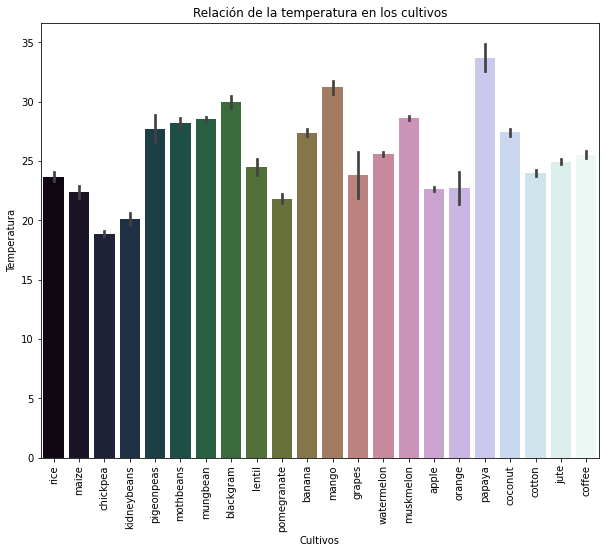

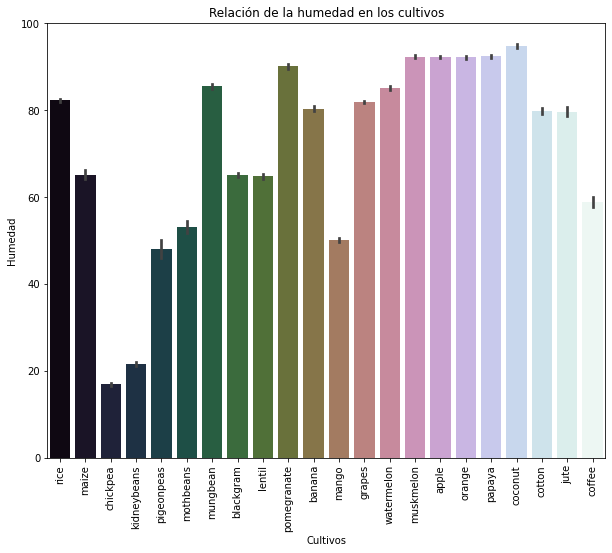

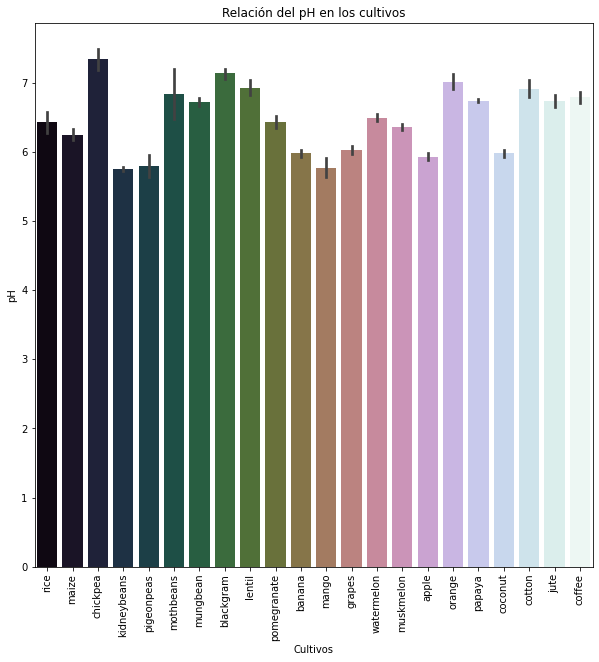

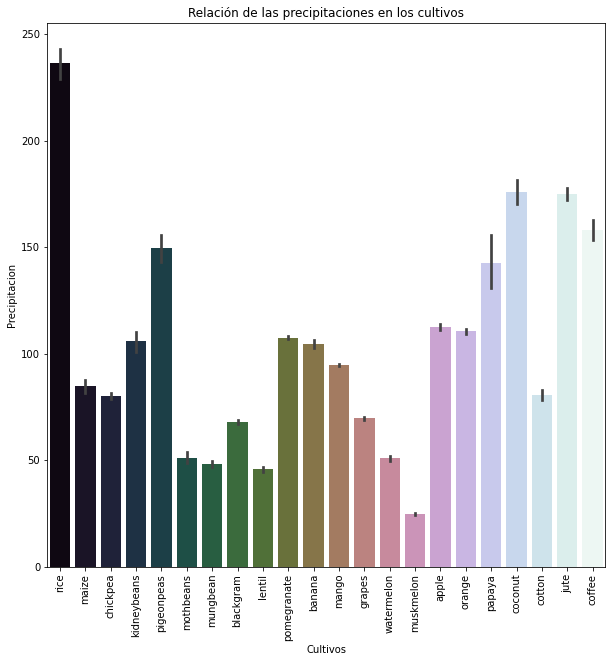

In [13]:
plt.figure(figsize=(10,8))
plt.title("Relación de la temperatura en los cultivos")
sns.barplot(y="Temperatura",x="Cultivo", data=df,palette='cubehelix')
plt.xticks(rotation='vertical')
plt.ylabel("Temperatura")
plt.xlabel("Cultivos")
plt.figure(figsize=(10,8))
plt.title("Relación de la humedad en los cultivos")
sns.barplot(y="Humedad",x="Cultivo", data=df,palette="cubehelix")
plt.xticks(rotation='vertical')
plt.ylabel("Humedad")
plt.xlabel("Cultivos")
plt.figure(figsize=(10,10))
plt.title("Relación del pH en los cultivos")
sns.barplot(y="PH",x="Cultivo", data=df,palette="cubehelix")
plt.xticks(rotation='vertical')
plt.ylabel("pH")
plt.xlabel("Cultivos")
plt.figure(figsize=(10,10))
plt.title("Relación de las precipitaciones en los cultivos")
sns.barplot(y="Precipitacion",x="Cultivo", data=df,palette="cubehelix")
plt.xticks(rotation='vertical')
plt.ylabel("Precipitacion")
plt.xlabel("Cultivos")

- Estos gráficos pueden ayudar a identificar patrones o relaciones entre las variables y los cultivos. 
- Se puede observar que un cultivo en particular tiende a crecer mejor en condiciones de alta humedad y temperatura moderada, mientras que otro cultivo podría requerir condiciones más secas y un pH específico para crecer adecuadamente. Es importante tener en cuenta que cada cultivo requiere factores particulares y muchas veces esto depende de la región en cuestión. 


#### Parallel Coordinates Plot

In [230]:
def plot_parallel_coordinates(df, title):
    dfg = pd.DataFrame({'Cultivo':df['Cultivo'].unique()})
    dfg['dummy'] = dfg.index
    df = pd.merge(df, dfg, on = 'Cultivo', how='left')

    dimensions = [dict(range=[0,df['dummy'].max()], tickvals=dfg['dummy'], ticktext=dfg['Cultivo'], label='Cultivos', values=df['dummy']),
                  dict(range=[df['Nitrogeno(N)'].min(), df['Nitrogeno(N)'].max()], label='Nitrogeno(N)', values=df['Nitrogeno(N)']),
                  dict(range=[df['Fosforo(P)'].min(), df['Fosforo(P)'].max()], label='Fosforo(P)', values=df['Fosforo(P)']),
                  dict(range=[df['Potasio(K)'].min(), df['Potasio(K)'].max()], label='Potasio(K)', values=df['Potasio(K)']),
                  dict(range=[df['Temperatura'].min(), df['Temperatura'].max()], label='Temperatura', values=df['Temperatura']),
                  dict(range=[df['Humedad'].min(), df['Humedad'].max()], label='Humedad', values=df['Humedad']),
                  dict(range=[df['PH'].min(), df['PH'].max()], label='pH', values=df['PH']),
                  dict(range=[df['Precipitacion'].min(), df['Precipitacion'].max()], label='Precipitaciones', values=df['Precipitacion'])]

    fig = go.Figure(data=go.Parcoords(line=dict(color=df['dummy'], colorscale='YlGnBu'), dimensions=dimensions))
    fig.update_layout(height=550, width=1000, title=title, title_font_size=20, title_x=0.5, title_y=0.95)
    fig.show()

df2 = df
plot_parallel_coordinates(df2, 'Distribución de características de los cultivos')


- Este gráfico es una representación de una matriz de coordenadas paralelas (parallel coordinates plot) que muestra la distribución de las características de los cultivos en el conjunto de datos. Cada línea representa un cultivo diferente y cada eje representa una característica diferente: Nitrógeno, Fósforo, Potasio, temperatura, humedad, pH y precipitaciones. El color de cada línea se relaciona con la etiqueta del cultivo. El gráfico se utiliza para explorar la relación entre las diferentes características y cómo difieren entre los cultivos diferentes.
- Este tipo de gráfico puede ayudar a identificar patrones en los datos y a comparar la distribución de las características entre los diferentes cultivos. Es muy útil para realizar comparaciones entre cultivos de manera rápida. 
- Por ejemplo en la columna "Potasio(K)" se puede observar que los requerimientos de potasio en todas las clases son altos o medio-bajo, por lo que se decidió hacer subsets para observar con mayor claridad si hay otros patrones. 
- Se pensó que podría ser útil hacer subsets con los tipos de cultivos encontrados en el data set, eligiendo los siguiente grupos:
1. Frutales 
2. Hortalizas fruto
3. Cereales 
4. Leguminosas
5. Textiles

In [186]:
df_frutales = df[df['Cultivo'].isin(['apple', 'banana', 'pomegranate', 'papaya', 'orange', 'mango', 'grapes', 'coffee', 'coconut'])]

In [226]:
df_F = df_frutales
plot_parallel_coordinates(df_F, 'Distribución de características de cultivos Frutales')

- En este gráfico se puede observar fácilmente que hay un patrón en la culumna "Potasio (K)". Hay varias clases de cultivos que requieren un contenido medio-bajo de potasio (granada, banana, mango, naranjas, papaya, coco, café, y otras que requieren alto contenido de potasio (manzanas y uvas).

In [17]:
df_hortalizas_fruto = df[df['Cultivo'].isin(['muskmelon', 'watermelon'])]

In [222]:
df_H = df_hortalizas_fruto
plot_parallel_coordinates(df_H, 'Distribución de características de cultivos Hortícolas (fruto)')

In [19]:
df_cereales = df[df['Cultivo'].isin(['rice', 'maize'])]

In [221]:
df_C = df_cereales
plot_parallel_coordinates(df_C, 'Distribución de características de cultivos de Cereales')

In [190]:
df_leguminosas = df[df['Cultivo'].isin(['pigeonpeas', 'mungbean', 'mothbeans', 'lentil', 'kidneybeans', 'chickpea', 'blackgram'])]

In [225]:
df_L = df_leguminosas
plot_parallel_coordinates(df_L, 'Distribución de características de cultivos de Leguminosas')

- En este gráfico se puede observar fácilmente que hay un patrón en la culumna "Potasio (K)". Todas las clases incluídas en "Cultivos tipo leguminosas" con excepción del garbanzo requieren bajo contenido de potasio en el suelo, en cambio el garbanzo requiere alto contenido de potasio en el suelo. 

In [194]:
df_textiles = df[df['Cultivo'].isin(['jute', 'cotton'])]

In [224]:
df_T = df_textiles
plot_parallel_coordinates(df_T, 'Distribución de características de cultivos de Textiles')

- Como análisis general de los gráficos anteriores se puede concluir que el patrón encontrado en muchas clases es el potasio, aunque no en todas. 


#### Pair Plot
- Utilizando un gráfico de pares, se visualiza el punto óptimo de cada cultivo para un par de factores.

- Si se necesita hacer "zoom" en cualquiera de estos pares de características, se puede utilizar sns.jointplot().

Text(0.5, 1.0, 'Gráfico de pares en los cultivos')

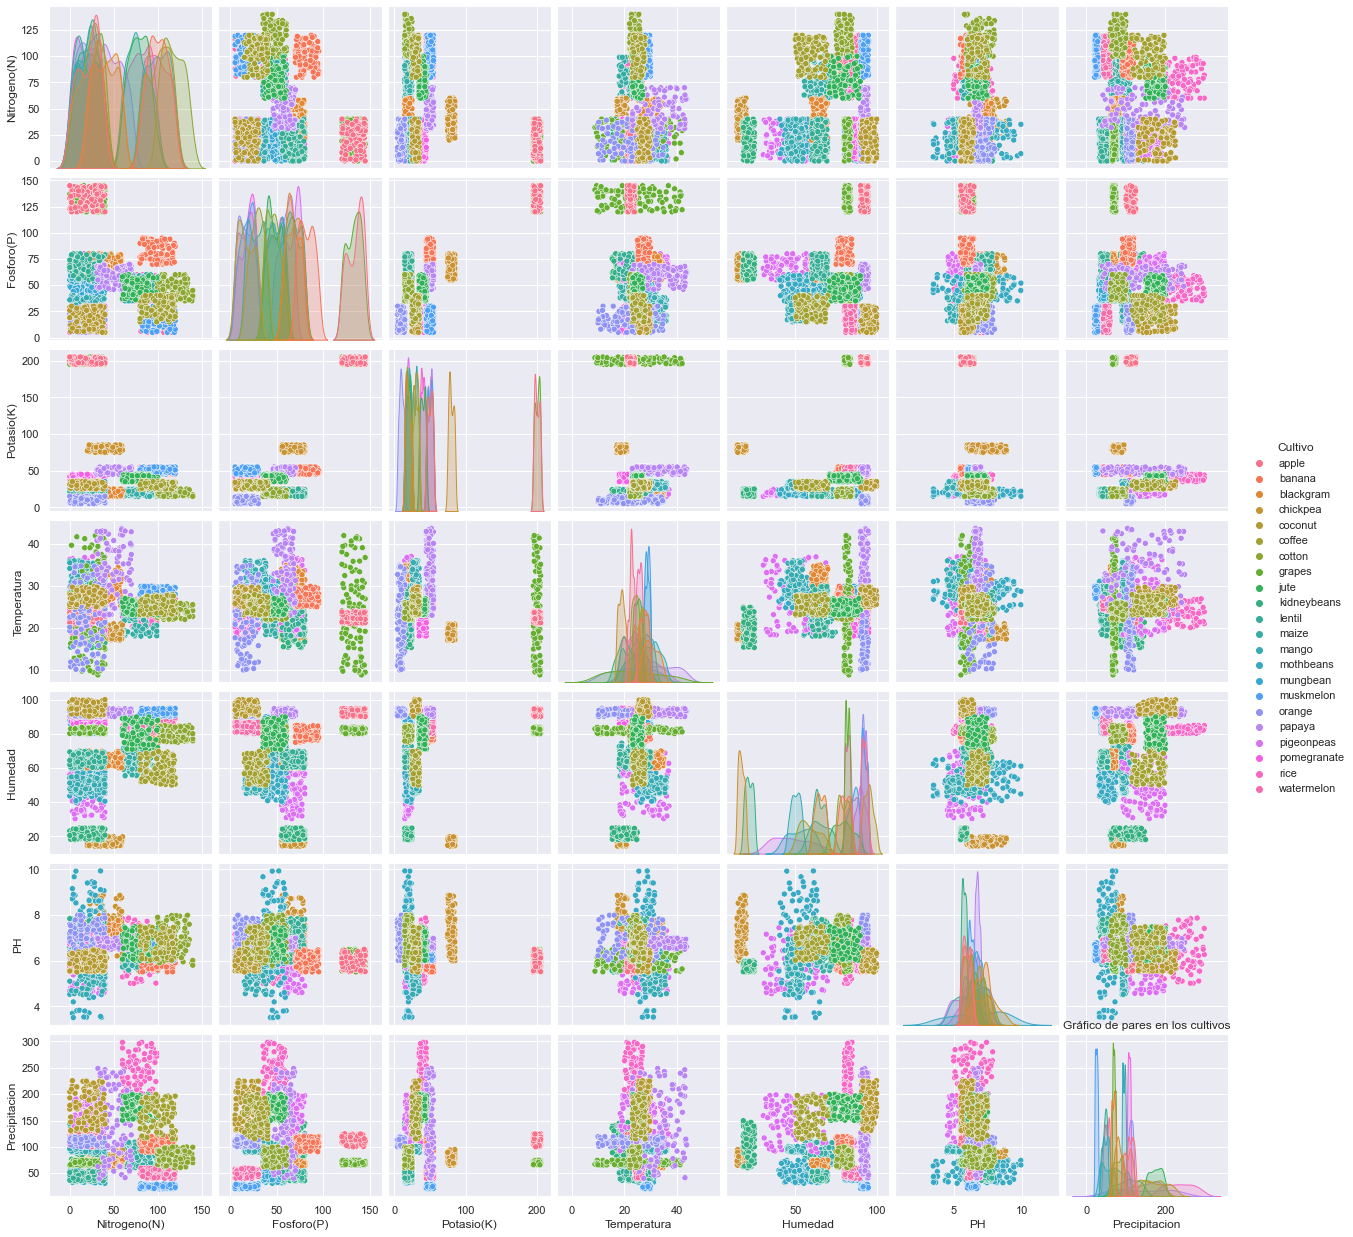

In [197]:
sns.pairplot(df, hue = 'Cultivo')
plt.title("Gráfico de pares en los cultivos")

#### Heat Map

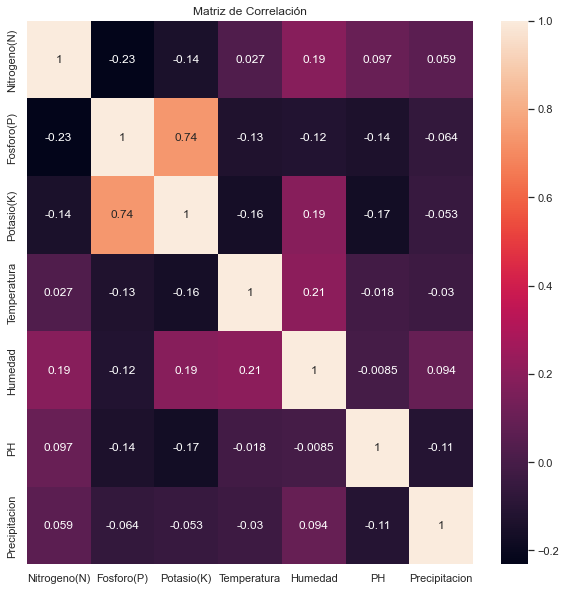

In [198]:
plt.figure(figsize=(10, 10))
matriz_corr = df.corr()
plt.title("Matriz de Correlación")
sns.heatmap(matriz_corr, annot=True)
plt.show()

**Correlaciones**

- Las correlaciones de las variables pueden interferir en el entrenamiento de algunos tipos de modelos porque las características no funcionan de forma independiente. Comprobando la correlación, se observa que sólo hay una correlación leve excepto para el Fósforo y el Potasio. Estos dos nutrientes son necesarios para el desarrollo de las plantas y se suelen hacer fertilizaciones que contienen estos nutrientes y el nitrógeno. 

## Preprocesado de los datos

#### Es importante conocer qué tipo de distribución tienen los features, por ejemplo, si tienen una distribución de tipo normal (gaussiana) o no, si hay outliers, etc, lo que determinará el tipo de preprocesado a realizar.

<Figure size 1440x720 with 0 Axes>

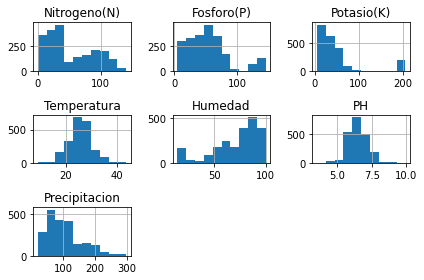

In [27]:
plt.figure(figsize = (20,10))
df.hist()
plt.tight_layout()

#### Box Plot

<AxesSubplot:title={'center':'Box Plot factores en cultivos'}>

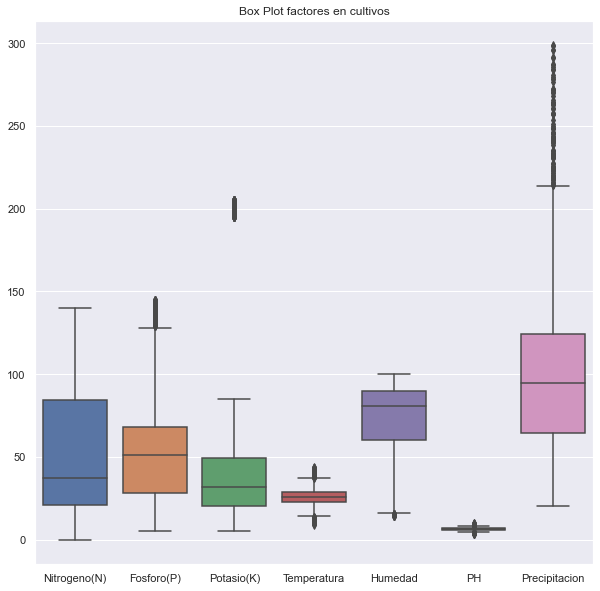

In [199]:
plt.figure(figsize=(10, 10))
plt.title("Box Plot factores en cultivos")
sns.boxplot(data=df)

In [29]:
df['Cultivo'] = df['Cultivo'].astype('category')
print(*df.dtypes)

int64 int64 int64 float64 float64 float64 float64 category


<Figure size 432x288 with 0 Axes>

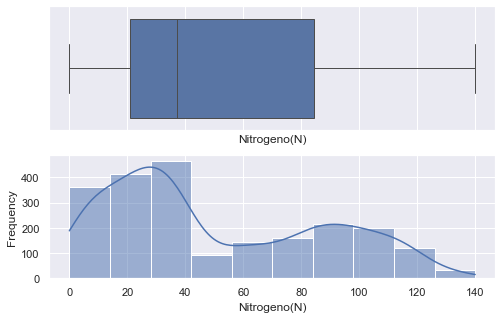

<Figure size 576x360 with 0 Axes>

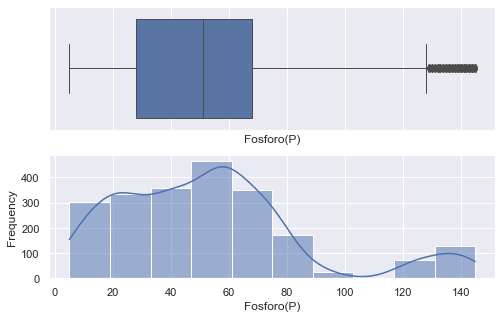

<Figure size 576x360 with 0 Axes>

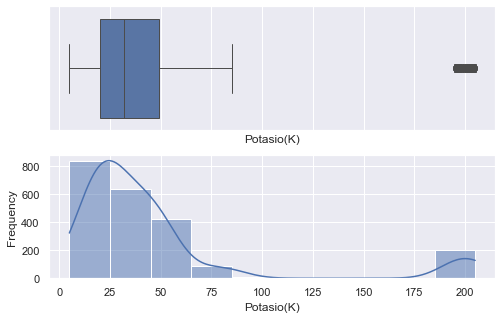

<Figure size 576x360 with 0 Axes>

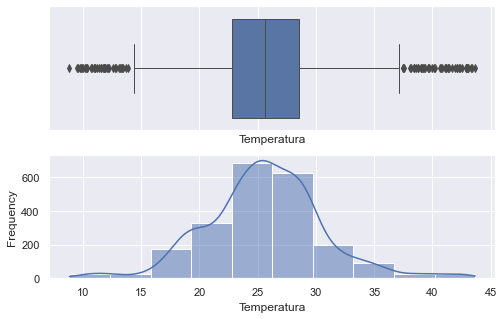

<Figure size 576x360 with 0 Axes>

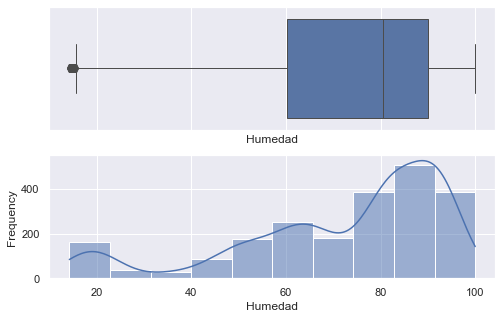

<Figure size 576x360 with 0 Axes>

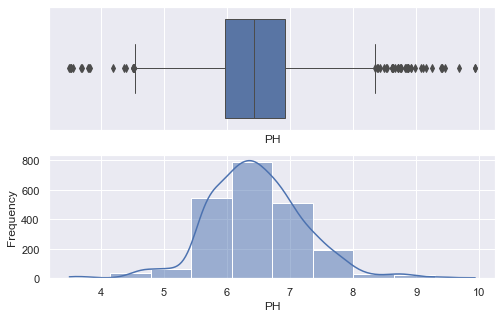

<Figure size 576x360 with 0 Axes>

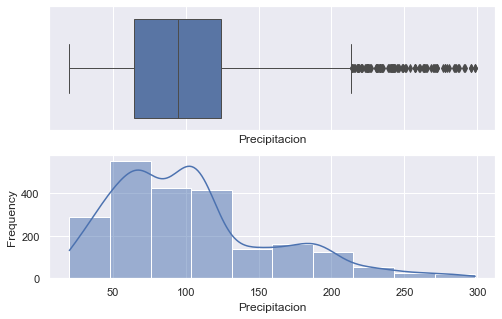

In [30]:
for i in df[['Nitrogeno(N)', 'Fosforo(P)', 'Potasio(K)', 'Temperatura', 'Humedad', 'PH', 'Precipitacion']]:
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(8, 5)})
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Frequency')
    sns.boxplot(df[i],  ax=ax_box , linewidth= 1.0)
    sns.histplot(df[i], ax=ax_hist , bins = 10,kde=True)

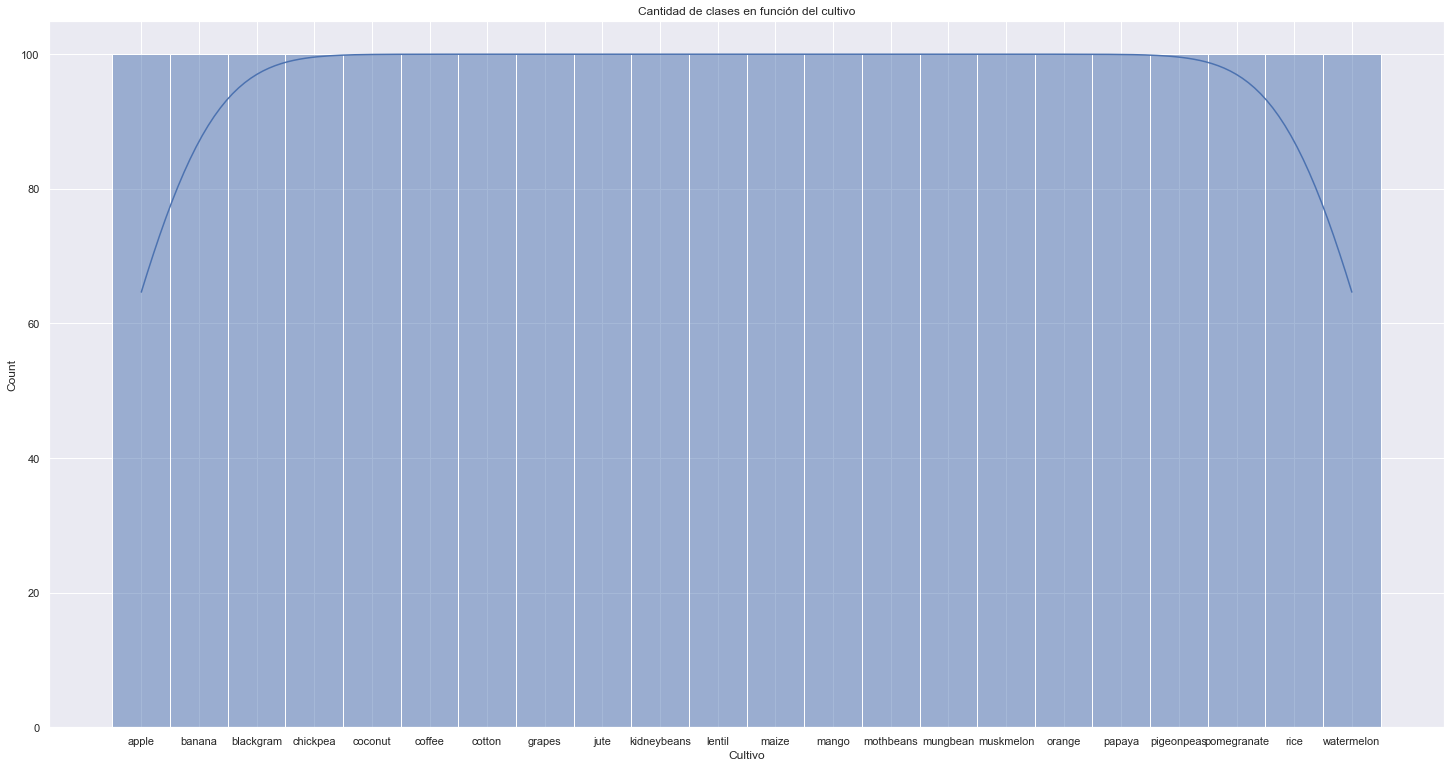

In [200]:
for i in df[['Cultivo']]:
    plt.figure(figsize = (25, 13))
    plt.title("Cantidad de clases en función del cultivo")
    sns.histplot(df[i] , bins = 10,kde=True)

#### Test de Hipótesis (Shapiro)

In [32]:
from scipy import stats

print('Hipotesis nula (Ho): La muestra tiene una distribución normal (Probablemente Gaussiana).')
print('Hipotesis alternativa (H1): La muestra no tiene una distribución normal (Probablemente no Gaussiana).\n')

for i in df[['Nitrogeno(N)', 'Fosforo(P)', 'Potasio(K)', 'Temperatura', 'Humedad', 'PH', 'Precipitacion']]:
    shapiro_test = stats.shapiro(df[i])
    print('La variable', i, 'tiene un p-value= ', shapiro_test.pvalue)
    if shapiro_test.pvalue > 0.05:
        print('Se acepta la hipotesis nula, la muestra tiene una distribución normal (Probablemente Gaussiana).\n')
    else:
        print('Se rechaza la hipotesis nula, la muestra no tiene una distribución normal (Probablemente no Gaussiana).\n')

Hipotesis nula (Ho): La muestra tiene una distribución normal (Probablemente Gaussiana).
Hipotesis alternativa (H1): La muestra no tiene una distribución normal (Probablemente no Gaussiana).

La variable Nitrogeno(N) tiene un p-value=  2.1306522038165223e-33
Se rechaza la hipotesis nula, la muestra no tiene una distribución normal (Probablemente no Gaussiana).

La variable Fosforo(P) tiene un p-value=  4.705700873480876e-34
Se rechaza la hipotesis nula, la muestra no tiene una distribución normal (Probablemente no Gaussiana).

La variable Potasio(K) tiene un p-value=  0.0
Se rechaza la hipotesis nula, la muestra no tiene una distribución normal (Probablemente no Gaussiana).

La variable Temperatura tiene un p-value=  5.256294717922083e-16
Se rechaza la hipotesis nula, la muestra no tiene una distribución normal (Probablemente no Gaussiana).

La variable Humedad tiene un p-value=  8.311465529511215e-40
Se rechaza la hipotesis nula, la muestra no tiene una distribución normal (Probableme

- Ninguna variable tiene una distribución normal.
- Las variables: Fosforo(P), Potasio(K), Temperatura, Humedad, PH y Precipitación contienen outliers por lo que se les aplicará RobustScaler.
- La variable: Nitrogeno(N) no contiene outliers por lo que se hará una Normalización Mín-Máx.

### Transformación de los datos 
- Se realizará el preprocesado de los datos mediante el uso de Pipeline.

In [33]:
numeric_features = ['Fosforo(P)', 'Potasio(K)', 'Temperatura', 'Humedad', 'PH', 'Precipitacion']
numeric_transformer = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'median')),
        ('robust', RobustScaler())
    ]
)

numeric_features_minmax = ['Nitrogeno(N)']
numeric_transformer_minmax = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'median')),
        ('minmax', MinMaxScaler())
    ]
)

#### Una vez que fueron creadas todas las pipelines, se utilizará ColumnTransformer para transformar cada una de las variables elegidas y luego poder utilizarlas en el modelo predictivo.

In [34]:
preprocessor = ColumnTransformer(
    [
        ('numericals', numeric_transformer, numeric_features),
        ('numericals_minmax', numeric_transformer_minmax, numeric_features_minmax)
        
    ],
    remainder = 'drop'
)

In [35]:
#preprocessor.fit_transform(df)

## Modelo predictivo

#### Se realizará la división de Features y Target

In [36]:
X = df.drop('Cultivo', axis = 1)
y = df.Cultivo

In [37]:
y.value_counts()

apple          100
banana         100
rice           100
pomegranate    100
pigeonpeas     100
papaya         100
orange         100
muskmelon      100
mungbean       100
mothbeans      100
mango          100
maize          100
lentil         100
kidneybeans    100
jute           100
grapes         100
cotton         100
coffee         100
coconut        100
chickpea       100
blackgram      100
watermelon     100
Name: Cultivo, dtype: int64

#### Se realizará la división en Train y Test

In [38]:
rfc = RandomForestClassifier(random_state = 42)
## Pipeline
pipeline = Pipeline([
            ('preprocessing', preprocessor),
            ('model', rfc)
        ])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
pipeline.fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(pipeline.score(X_test, y_test)))

R2 score: 0.99


In [41]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1760, 7) (440, 7) (1760,) (440,)


In [42]:
from imblearn.pipeline import Pipeline
pipeline.predict(X_test)

array(['muskmelon', 'watermelon', 'papaya', 'papaya', 'apple', 'mango',
       'apple', 'mothbeans', 'mungbean', 'lentil', 'blackgram', 'coconut',
       'pomegranate', 'jute', 'coconut', 'pomegranate', 'apple', 'maize',
       'papaya', 'muskmelon', 'coffee', 'papaya', 'orange', 'papaya',
       'chickpea', 'jute', 'mungbean', 'orange', 'pigeonpeas', 'rice',
       'pomegranate', 'mothbeans', 'jute', 'lentil', 'jute', 'blackgram',
       'jute', 'chickpea', 'chickpea', 'kidneybeans', 'papaya', 'mango',
       'blackgram', 'maize', 'mungbean', 'maize', 'pigeonpeas', 'coconut',
       'muskmelon', 'maize', 'blackgram', 'coffee', 'grapes', 'mungbean',
       'coffee', 'kidneybeans', 'cotton', 'apple', 'banana', 'blackgram',
       'watermelon', 'coconut', 'lentil', 'orange', 'papaya',
       'pigeonpeas', 'orange', 'rice', 'muskmelon', 'pigeonpeas',
       'muskmelon', 'coconut', 'jute', 'banana', 'blackgram', 'papaya',
       'banana', 'cotton', 'watermelon', 'orange', 'coffee', 'chickp

In [43]:
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numericals',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['Fosforo(P)', 'Potasio(K)',
                                                   'Temperatura', 'Humedad',
                                                   'PH', 'Precipitacion']),
                                                 ('numericals_minmax',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('

In [44]:
#!pip install lightgbm

#### Se buscará el mejor modelo

- Se utilizará un nuevo pipeline, creado a partir del ColumnTransformer, para encontrar el mejor modelo. 

In [45]:
## Loop per trobar el millor model

lda = LinearDiscriminantAnalysis()
knc = KNeighborsClassifier()
gnb = GaussianNB()
dtc = DecisionTreeClassifier(random_state = 42)
svc = SVC(random_state = 42) #(gamma = 'auto')
rfc = RandomForestClassifier(random_state = 42)
lr = LogisticRegression()
gbc = GradientBoostingClassifier(random_state= 42)
lgb = lgb.LGBMClassifier(random_state= 42)

In [46]:
evaluation = pd.DataFrame({'model':['lda','knc','gnb','dtc', 'svc','rfc', 'lr', 'gbc',  'lgb']}) 

In [47]:
models = [lda, knc, gnb, dtc, svc, rfc, lr, gbc, lgb]
score_mean = []
score_std = []

for model in models:
    pipeline = Pipeline(
        [
            ('preprocessing', preprocessor),
            ('model', model)
        ]
    )
    score = cross_validate(pipeline, X, y, cv=5, scoring='f1_macro', return_estimator=True)
    
    score_mean.append(np.mean(score['test_score']))
    score_std.append(np.std(score['test_score']))


In [48]:
evaluation['f1_macro_cv'] = score_mean # quizas deba dejar f1 en vez de f1 macro
evaluation['f1_macro_std_cv'] = score_std
evaluation

model  f1_macro_cv  f1_macro_std_cv
0   lda     0.964902         0.007095
1   knc     0.976718         0.004731
2   gnb     0.994979         0.002260
3   dtc     0.987236         0.003416
4   svc     0.981394         0.001587
5   rfc     0.993612         0.003943
6    lr     0.964410         0.008069
7   gbc     0.991382         0.003920
8   lgb     0.989125         0.003901

- Se eligirán los modelos **GaussianNB**, **RandomForestClassifier** y **GradientBoostingClassifier**, ya que son los que mayor F1 obtuvieron.

## Buscando mejores parametros
- Se buscarán los mejores parametros de los modelos elegidos.

In [49]:
pipeline_gnb = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', GaussianNB())
    ]
)

params_gnb = {}

rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 42)

cv_gnb = GridSearchCV(pipeline_gnb, params_gnb, cv = rskf, scoring = ['f1_macro', 'accuracy'], refit = 'f1_macro', n_jobs = -1)



cv_gnb.fit(X, y)

print(f'Best F1_macro-score: {cv_gnb.best_score_:.3f}\n')
print(f'Best parameter set: {cv_gnb.best_params_}\n')
print(f'Scores: {classification_report(y, cv_gnb.predict(X))}')


Best F1_macro-score: 0.995

Best parameter set: {}

Scores:               precision    recall  f1-score   support

       apple       1.00      1.00      1.00       100
      banana       1.00      1.00      1.00       100
   blackgram       1.00      1.00      1.00       100
    chickpea       1.00      1.00      1.00       100
     coconut       1.00      1.00      1.00       100
      coffee       1.00      1.00      1.00       100
      cotton       0.99      1.00      1.00       100
      grapes       1.00      1.00      1.00       100
        jute       0.92      0.98      0.95       100
 kidneybeans       1.00      1.00      1.00       100
      lentil       1.00      1.00      1.00       100
       maize       1.00      0.99      0.99       100
       mango       1.00      1.00      1.00       100
   mothbeans       1.00      1.00      1.00       100
    mungbean       1.00      1.00      1.00       100
   muskmelon       1.00      1.00      1.00       100
      orange       1.

In [50]:
pipeline_rfc = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', RandomForestClassifier(random_state = 42))
    ]
)

params_rfc = {
    'model__criterion':('gini', 'entropy'),
    'model__n_estimators': [10, 50, 100, 200, 500],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__class_weight': [None],
    'model__random_state': [42]
}

rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 42)

cv_rfc = GridSearchCV(pipeline_rfc, params_rfc, cv = rskf, scoring = ['f1_macro', 'accuracy'], refit = 'f1_macro', n_jobs = -1)



cv_rfc.fit(X, y)

print(f'Best F1_macro-score: {cv_rfc.best_score_:.3f}\n')
print(f'Best parameter set: {cv_rfc.best_params_}\n')
print(f'Scores: {classification_report(y, cv_rfc.predict(X))}')

Best F1_macro-score: 0.996

Best parameter set: {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'auto', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 50, 'model__random_state': 42}

Scores:               precision    recall  f1-score   support

       apple       1.00      1.00      1.00       100
      banana       1.00      1.00      1.00       100
   blackgram       1.00      1.00      1.00       100
    chickpea       1.00      1.00      1.00       100
     coconut       1.00      1.00      1.00       100
      coffee       1.00      1.00      1.00       100
      cotton       1.00      1.00      1.00       100
      grapes       1.00      1.00      1.00       100
        jute       1.00      1.00      1.00       100
 kidneybeans       1.00      1.00      1.00       100
      lentil       1.00      1.00      1.00       100
       maize       1.00      1.00      1.00       100
       man

In [51]:
pipeline_gbc = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', GradientBoostingClassifier(random_state= 42))
    ]
)

params_gbc = {
    'model__criterion': ['friedman_mse', 'mse'],
    'model__loss': ['deviance', 'exponential'],
    'model__n_estimators': [10, 50, 100, 200, 500],
    'model__random_state': [42],
    'model__max_depth': [1, 3, 5],
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__learning_rate': [0.1, 0.05, 0.01]
   
}

rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 42)

cv_gbc = GridSearchCV(pipeline_gbc, params_gbc, cv = rskf, scoring = ['f1_macro', 'accuracy'], refit = 'f1_macro', n_jobs = -1)



cv_gbc.fit(X, y)

print(f'Best F1_macro-score: {cv_gbc.best_score_:.3f}\n')
print(f'Best parameter set: {cv_gbc.best_params_}\n')
print(f'Scores: {classification_report(y, cv_gbc.predict(X))}')

Best F1_macro-score: 0.996

Best parameter set: {'model__criterion': 'friedman_mse', 'model__learning_rate': 0.1, 'model__loss': 'deviance', 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__n_estimators': 100, 'model__random_state': 42}

Scores:               precision    recall  f1-score   support

       apple       1.00      1.00      1.00       100
      banana       1.00      1.00      1.00       100
   blackgram       1.00      1.00      1.00       100
    chickpea       1.00      1.00      1.00       100
     coconut       1.00      1.00      1.00       100
      coffee       1.00      1.00      1.00       100
      cotton       1.00      1.00      1.00       100
      grapes       1.00      1.00      1.00       100
        jute       1.00      1.00      1.00       100
 kidneybeans       1.00      1.00      1.00       100
      lentil       1.00      1.00      1.00       100
       maize       1.00      1.00      1.00       100
       mango       1.00      1.00     

In [52]:
cv_gnb.cv_results_

{'mean_fit_time': array([0.06749752]),
 'std_fit_time': array([0.02216922]),
 'mean_score_time': array([0.02999527]),
 'std_score_time': array([0.01606322]),
 'params': [{}],
 'split0_test_f1_macro': array([0.99314325]),
 'split1_test_f1_macro': array([0.99544315]),
 'split2_test_f1_macro': array([0.99772585]),
 'split3_test_f1_macro': array([0.993169]),
 'split4_test_f1_macro': array([0.99317755]),
 'split5_test_f1_macro': array([0.99544315]),
 'split6_test_f1_macro': array([0.99314325]),
 'split7_test_f1_macro': array([0.99088631]),
 'split8_test_f1_macro': array([0.99772585]),
 'split9_test_f1_macro': array([0.99544315]),
 'mean_test_f1_macro': array([0.99453005]),
 'std_test_f1_macro': array([0.00209123]),
 'rank_test_f1_macro': array([1]),
 'split0_test_accuracy': array([0.99318182]),
 'split1_test_accuracy': array([0.99545455]),
 'split2_test_accuracy': array([0.99772727]),
 'split3_test_accuracy': array([0.99318182]),
 'split4_test_accuracy': array([0.99318182]),
 'split5_test_a

In [53]:
cv_rfc.cv_results_

{'mean_fit_time': array([0.14297607, 0.6210886 , 1.08779027, ..., 1.51676433, 3.02617483,
        6.162503  ]),
 'std_fit_time': array([0.03346867, 0.0678187 , 0.13590222, ..., 0.02779927, 0.11508853,
        0.52529546]),
 'mean_score_time': array([0.04029181, 0.0749032 , 0.08828926, ..., 0.07843211, 0.12057521,
        0.24537952]),
 'std_score_time': array([0.01371011, 0.01940808, 0.01398912, ..., 0.01054103, 0.01038043,
        0.02396523]),
 'param_model__class_weight': masked_array(data=[None, None, None, ..., None, None, None],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_model__criterion': masked_array(data=['gini', 'gini', 'gini', ..., 'entropy', 'entropy',
                    'entropy'],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_model__max_depth': masked_array(data=[None, None, None, ..., 20, 20, 20],
        

In [54]:
cv_gbc.cv_results_

{'mean_fit_time': array([1.91717403e+00, 6.97748368e+00, 1.36950561e+01, 2.64157790e+01,
        6.50624029e+01, 9.98116279e-01, 4.86309240e+00, 1.05197833e+01,
        1.80674336e+01, 4.43882528e+01, 8.15605783e-01, 4.80533667e+00,
        9.00323522e+00, 1.80610478e+01, 4.60037086e+01, 2.34743919e+00,
        1.40583889e+01, 3.28491912e+01, 4.79414613e+01, 6.95509778e+01,
        1.51134617e+00, 7.58929613e+00, 1.42220336e+01, 3.19263569e+01,
        6.51942815e+01, 2.25250130e+00, 8.34329708e+00, 1.92384654e+01,
        2.89670854e+01, 5.05900603e+01, 4.24126809e+00, 2.12978640e+01,
        3.69990415e+01, 4.33209098e+01, 6.46248294e+01, 2.06471093e+00,
        1.05289158e+01, 1.99820011e+01, 2.85477691e+01, 5.03903943e+01,
        2.04176362e+00, 1.02869516e+01, 1.99806540e+01, 3.53503718e+01,
        5.63249275e+01, 4.23275471e-02, 3.76153708e-02, 3.60977173e-02,
        4.09602880e-02, 3.70803356e-02, 4.28949594e-02, 5.23250580e-02,
        4.87598181e-02, 5.66543341e-02, 3.65114

### Mejora de los modelos

- Se aplicarán los mejores parámetros, encontrados anteriormente para observar si hay mejorías en las predicciones.

Accuracy score: 1.00


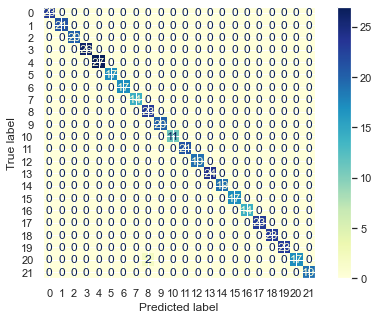

In [55]:
pipeline_gnb_bp = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', GaussianNB())
    ]
)

pipeline_gnb_bp.fit(X_train, y_train)
print('Accuracy score: {0:.2f}'.format(pipeline_gnb_bp.score(X_test, y_test)))

y_pred_gnb_bp = pipeline_gnb_bp.predict(X_test)

cm = confusion_matrix(y_test, y_pred_gnb_bp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap= 'YlGnBu')
plt.show()

Accuracy score: 1.00


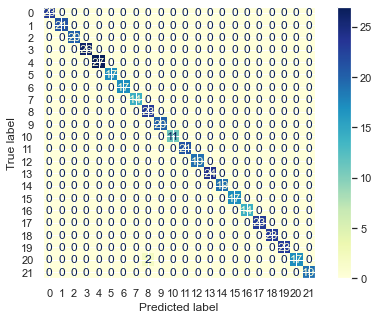

In [56]:
pipeline_rfc_bp = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', RandomForestClassifier(random_state=42, criterion='gini', max_depth= None, class_weight= None, max_features= 'auto', min_samples_leaf= 1, min_samples_split= 5, n_estimators= 50))
    ]
)

pipeline_rfc_bp.fit(X_train, y_train)
print('Accuracy score: {0:.2f}'.format(pipeline_rfc_bp.score(X_test, y_test)))

y_pred_rfc_bp = pipeline_rfc_bp.predict(X_test)

cm = confusion_matrix(y_test, y_pred_rfc_bp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap= 'YlGnBu')
plt.show()


Accuracy score: 0.991


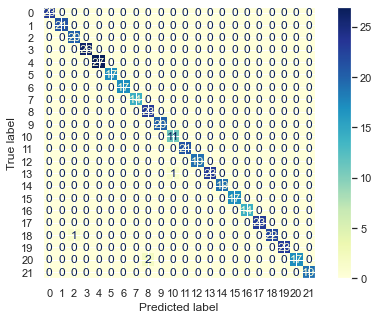

In [58]:
pipeline_gbc_bp = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', GradientBoostingClassifier(random_state= 42, criterion= 'friedman_mse', learning_rate= 0.1, loss= 'deviance', max_depth= 3, max_features= 'sqrt', n_estimators= 100))
    ]
)

pipeline_gbc_bp.fit(X_train, y_train)
print('Accuracy score: {0:.3f}'.format(pipeline_gbc_bp.score(X_test, y_test)))

y_pred_gbc_bp = pipeline_gbc_bp.predict(X_test)

cm = confusion_matrix(y_test, y_pred_gbc_bp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap= 'YlGnBu')
plt.show()


In [59]:
pipeline_gnb1 = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', GaussianNB())
    ]
)

score = cross_val_score(pipeline_gnb1, X, y, cv=5, scoring='f1_macro')
print('F1_macro score: {0:.3f}'.format(score.mean()))

F1_macro score: 0.995


In [60]:
pipeline_rfc1 = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', RandomForestClassifier(random_state= 42, criterion='gini', max_depth= None, class_weight= None, max_features= 'auto', min_samples_leaf= 1, min_samples_split= 5, n_estimators= 50))
    ]
)

score = cross_val_score(pipeline_rfc1, X, y, cv=5, scoring='f1_macro')
print('F1_macro score: {0:.3f}'.format(score.mean()))

F1_macro score: 0.995


In [61]:
pipeline_gbc1 = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', GradientBoostingClassifier(random_state= 42, criterion= 'friedman_mse', learning_rate= 0.1, loss= 'deviance', max_depth= 3, max_features= 'sqrt', n_estimators= 100))
    ]
)

score = cross_val_score(pipeline_gbc1, X, y, cv=5, scoring='f1_macro')
print('F1_macro score: {0:.3f}'.format(score.mean()))

F1_macro score: 0.993


- Se pueden observar valores de Acurracy casi del 100%, es decir que la calidad de las predicciones de los modelos elegidos es muy alta. Los mejores resultados se obtuvieron con los modelos : GaussianNB y RandomForestClassifier.
- Los valores de F1 también son muy elevados. Es llamativo que en los modelos RandomForestClassifier y GradientBoostingClassifier se produce un mínimo descenso luego de aplicar los mejores parámetros.
- Como se puede observar en las matrices de correlación son muy pocas las clases predichas erróneamente. 

### PCA

In [62]:
pipeline_gnb_pca = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('pca', PCA(n_components = 0.99)),
        ('model', GaussianNB())
    ]
)

score = cross_val_score(pipeline_gnb_pca, X, y, cv=5, scoring='f1_macro')
print('F1_macro score: {0:.3f}'.format(score.mean()))

F1_macro score: 0.948


In [63]:
pipeline_rfc_pca = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('pca', PCA(n_components = 0.99)),
        ('model', RandomForestClassifier(random_state= 42, criterion='gini', max_depth= None, class_weight= None, max_features= 'auto', min_samples_leaf= 1, min_samples_split= 5, n_estimators= 50))
    ]
)

score = cross_val_score(pipeline_rfc_pca, X, y, cv=5, scoring='f1_macro')
print('F1_macro score: {0:.3f}'.format(score.mean()))

F1_macro score: 0.971


In [64]:
pipeline_gbc_pca = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('pca', PCA(n_components = 0.99)),
        ('model', GradientBoostingClassifier(random_state= 42, criterion= 'friedman_mse', learning_rate= 0.1, loss= 'deviance', max_depth= 3, max_features= 'sqrt', n_estimators= 100))
    ]
)

score = cross_val_score(pipeline_gbc_pca, X, y, cv=5, scoring='f1_macro')
print('F1_macro score: {0:.3f}'.format(score.mean()))

F1_macro score: 0.959


- Como era de esperar, hay una disminución en el valor de F1 aplicando PCA debido a que hay una gran pérdida de información.


## Continuando con el análisis


#### Box Plot

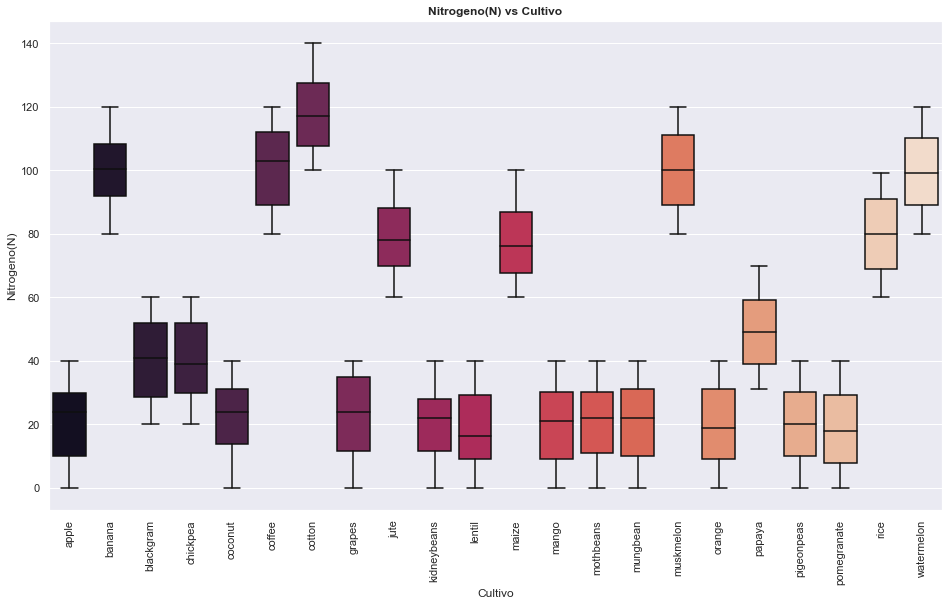

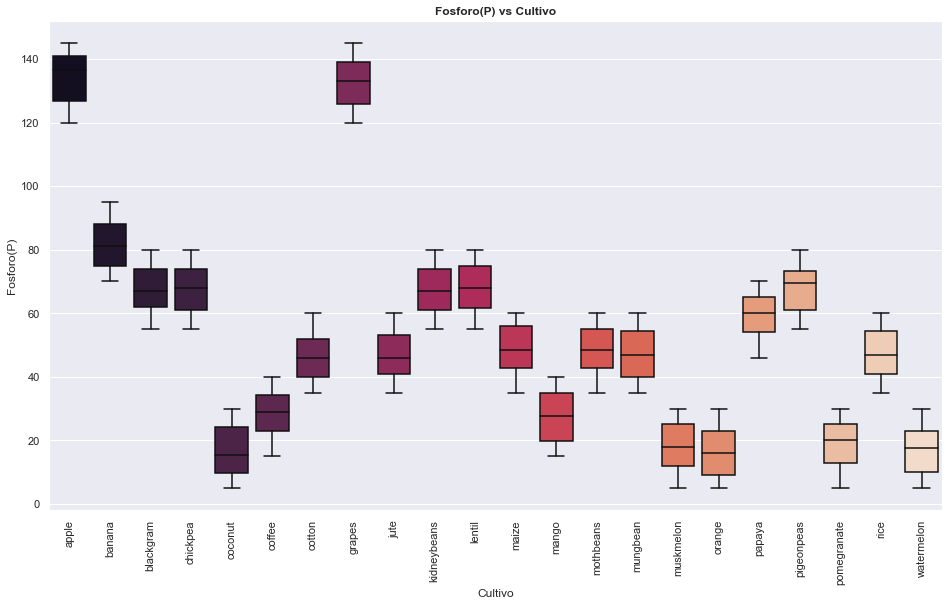

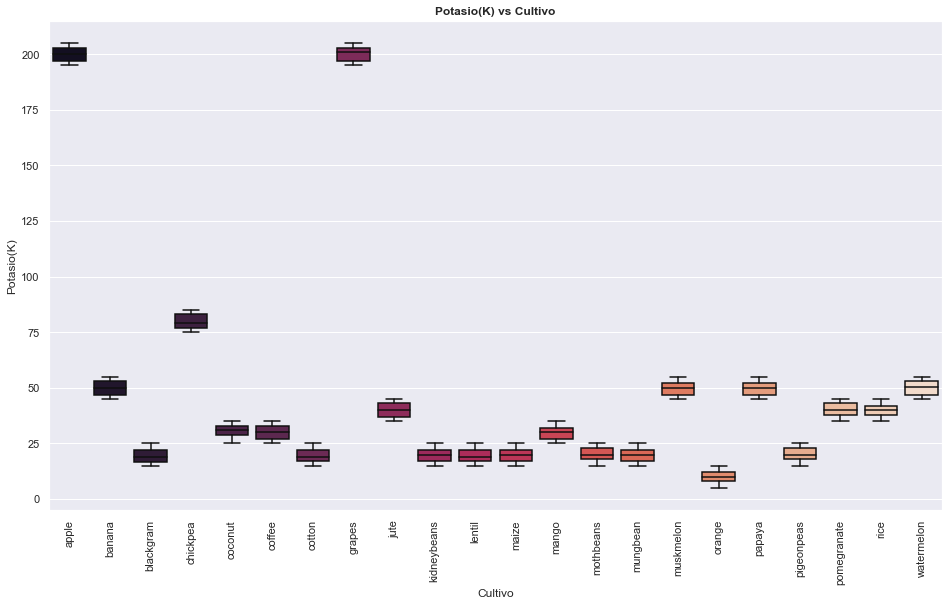

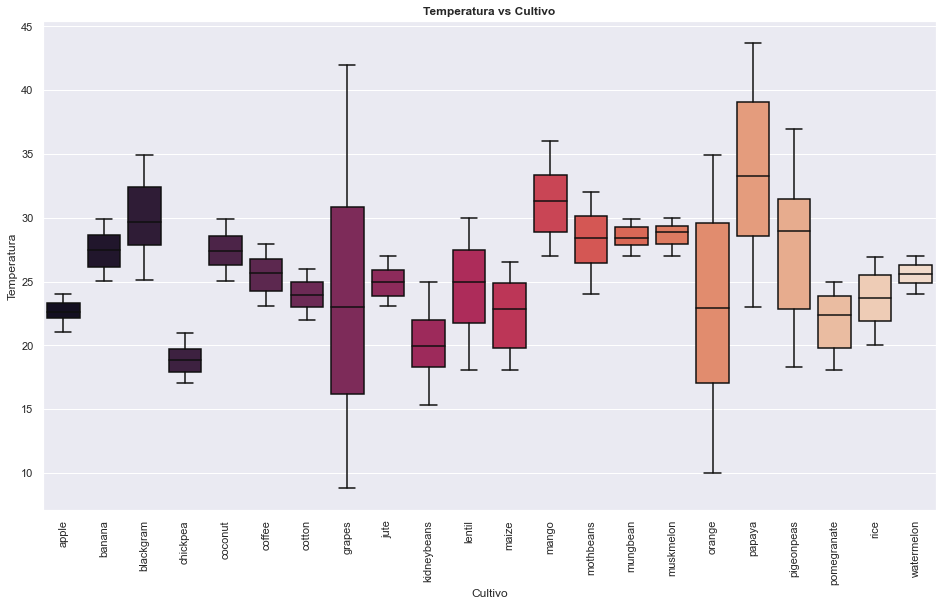

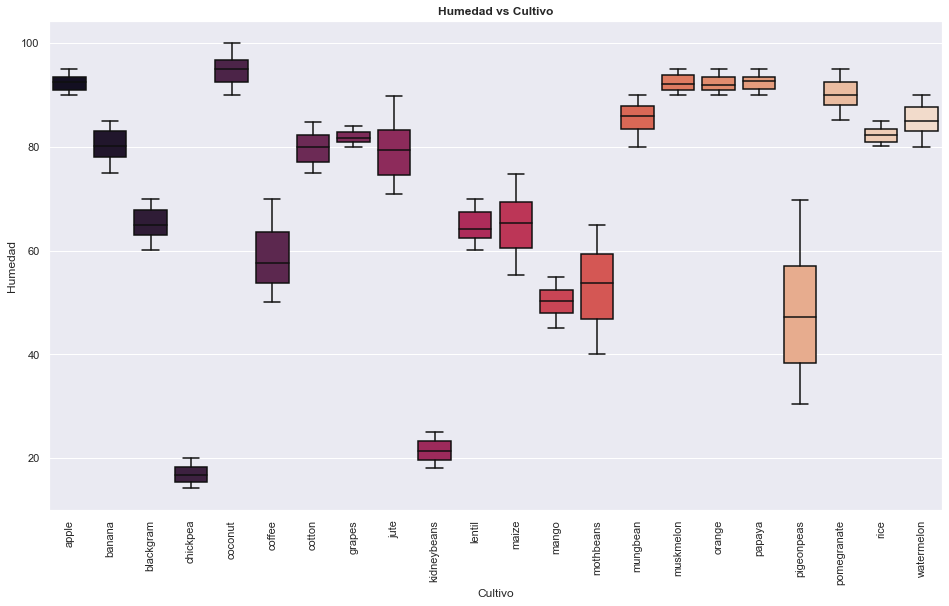

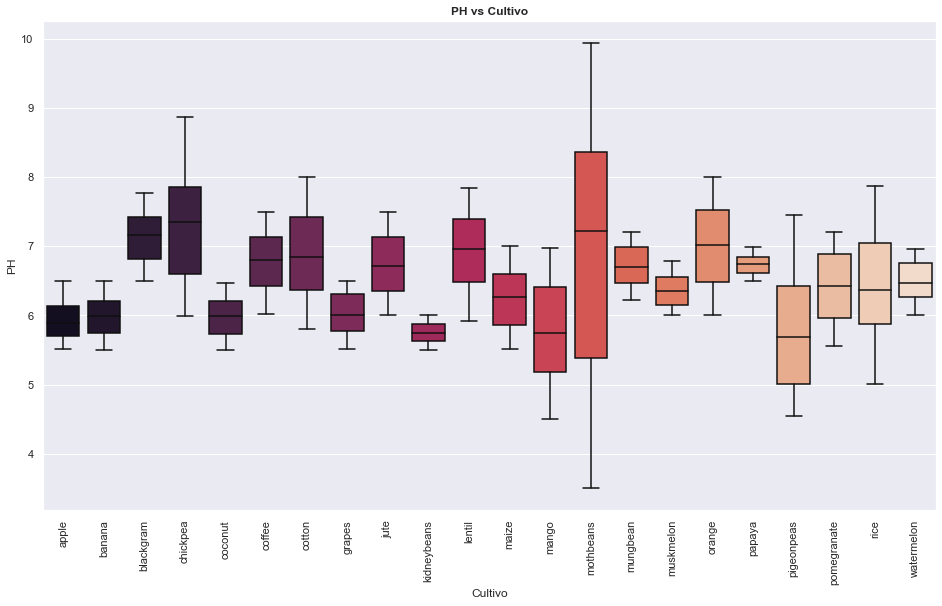

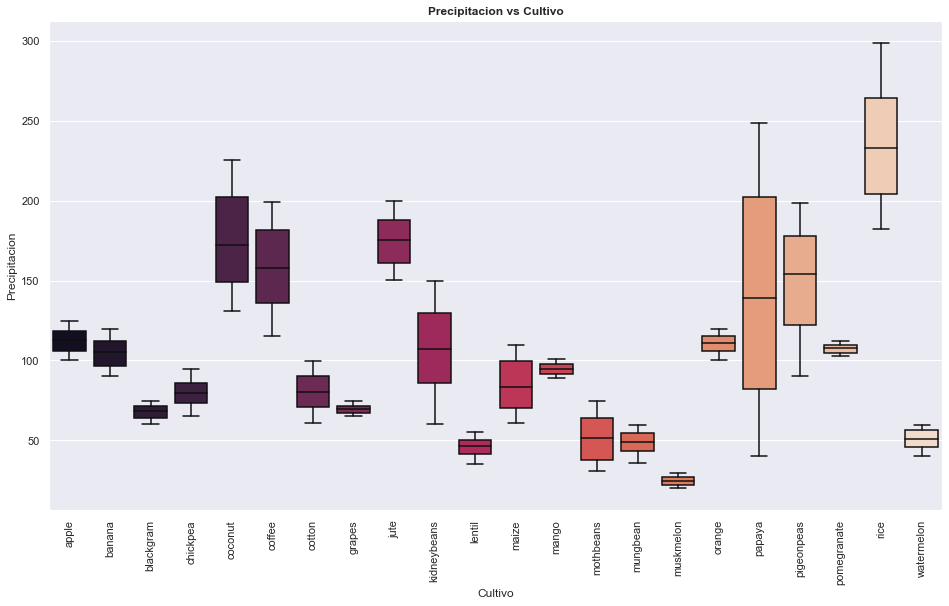

In [66]:
all_col = df.columns[:-1]

for col in all_col:
  plt.figure(figsize = (16, 9))
  sns.boxplot(x = 'Cultivo', y = col, data = df, palette = 'rocket')
  plt.xlabel('Cultivo', fontsize = 12)
  plt.ylabel(col, fontsize = 12)
  plt.xticks(rotation=90)
  plt.title(f'{col} vs Cultivo', fontweight='bold')
  plt.show()

Gracias a esta serie de gráficos se puede observar la influencia de los factores en cada cultivo.

Por ejemplo: 
- La temperatura me permite saber cuando voy a plantar/ sembrar. Generalmente nos permite diferencias los cultivos de primavera - verano y otoño - invierno. 
- En general, cuando la temperatura sube por encima de 21° C el pH disminuye 
- El pH óptimo para la mayoría de las plantas está entre 5,5 y 8 , dependiendo del tipo de cultivo.

In [67]:
cult_resumen = pd.pivot_table(df,index=['Cultivo'],aggfunc='mean')
cult_resumen

Fosforo(P)    Humedad  Nitrogeno(N)        PH  Potasio(K)  \
Cultivo                                                                  
apple            134.22  92.333383         20.80  5.929663      199.89   
banana            82.01  80.358123        100.23  5.983893       50.05   
blackgram         67.47  65.118426         40.02  7.133952       19.24   
chickpea          67.79  16.860439         40.09  7.336957       79.92   
coconut           16.93  94.844272         21.98  5.976562       30.59   
coffee            28.74  58.869846        101.20  6.790308       29.94   
cotton            46.24  79.843474        117.77  6.912676       19.56   
grapes           132.53  81.875228         23.18  6.025937      200.11   
jute              46.86  79.639864         78.40  6.732778       39.99   
kidneybeans       67.54  21.605357         20.75  5.749411       20.05   
lentil            68.36  64.804785         18.77  6.927932       19.41   
maize             48.44  65.092249         77.76  6.245190       19.79   
mango             27.18  50.156573         20.07  5.766373       29.92   
mothbeans         48.01  53.160418         21.44  6.831174       20.23   
mungbean          47.28  85.499975         20.99  6.723957       19.87   
muskmelon         17.72  92.342802        100.32  6.358805       50.08   
orange            16.55  92.170209         19.58  7.016957       10.01   
papaya            59.05  92.403388         49.88  6.741442       50.04   
pigeonpeas        67.73  48.061633         20.73  5.794175       20.29   
pomegranate       18.75  90.125504         18.87  6.429172       40.21   
rice              47.58  82.272822         79.89  6.425471       39.87   
watermelon        17.00  85.160375         99.42  6.495778       50.22   

             Precipitacion  Temperatura  
Cultivo                                  
apple           112.654779    22.630942  
banana          104.626980    27.376798  
blackgram        67.884151    29.973340  
chickpea         80.058977    18.872847  
coconut         175.686646    27.409892  
coffee          158.066295    25.540477  
cotton           80.398043    23.988958  
grapes           69.611829    23.849575  
jute            174.792798    24.958376  
kidneybeans     105.919777    20.115085  
lentil           45.680454    24.509052  
maize            84.766988    22.389204  
mango            94.704515    31.208770  
mothbeans        51.198487    28.194920  
mungbean         48.403601    28.525775  
muskmelon        24.689952    28.663066  
orange          110.474969    22.765725  
papaya          142.627839    33.723859  
pigeonpeas      149.457564    27.741762  
pomegranate     107.528442    21.837842  
rice            236.181114    23.689332  
watermelon       50.786219    25.591767

- En este resumen se puede observar de manera más clara los valores promedio de los diferentes factores que son necesarios en cada cultivo.

#### Bar Plot
- En los siguientes gráficos se observa la relación de los macronutrientes(Nitrógeno, Fósforo y Potasio) en los diferentes cultivos, siendo muy distintas requerimientos de dichos nutrientes.

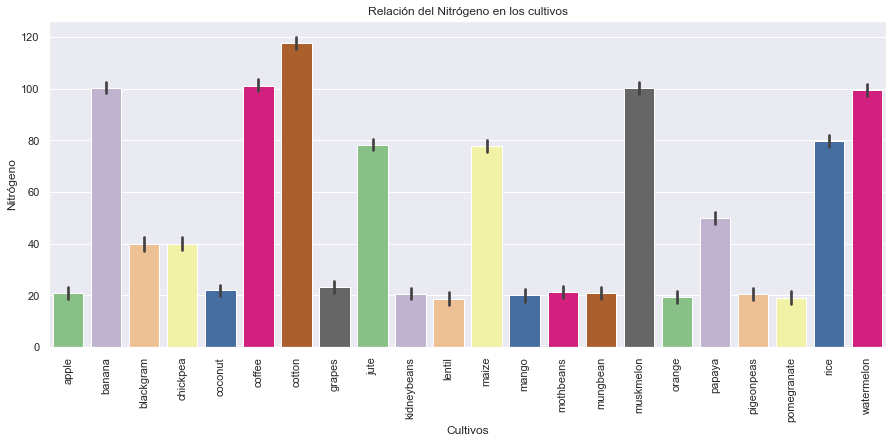

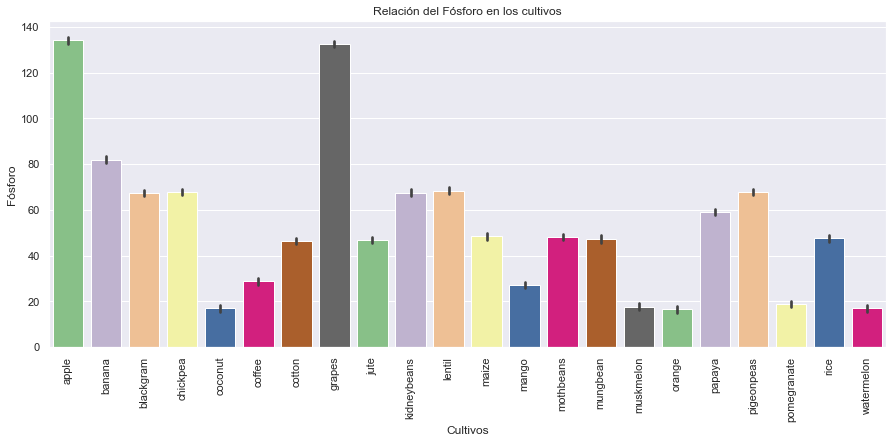

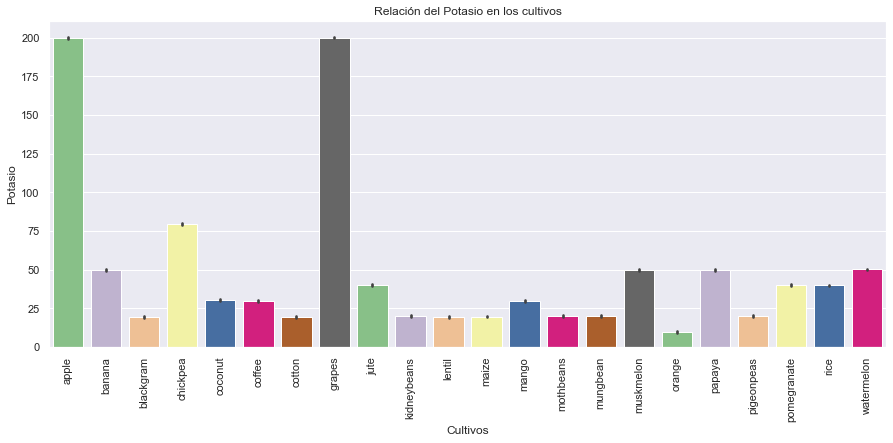

In [68]:
plt.figure(figsize=(15,6))
sns.barplot(y = 'Nitrogeno(N)', x = 'Cultivo', data=df, palette = 'Accent')
plt.xticks(rotation = 90)
plt.title("Relación del Nitrógeno en los cultivos")
plt.ylabel("Nitrógeno")
plt.xlabel("Cultivos")
plt.show()
plt.figure(figsize=(15,6))
sns.barplot(y = 'Fosforo(P)', x = 'Cultivo', data= df, palette = 'Accent')
plt.xticks(rotation = 90)
plt.title("Relación del Fósforo en los cultivos")
plt.ylabel("Fósforo")
plt.xlabel("Cultivos")
plt.show()
plt.figure(figsize=(15,6))
sns.barplot(y = 'Potasio(K)', x = 'Cultivo', data= df, palette = 'Accent')
plt.xticks(rotation = 90)
plt.title("Relación del Potasio en los cultivos")
plt.ylabel("Potasio")
plt.xlabel("Cultivos")
plt.show()

#### Se observa que la variable más influyente es el Potasio. 

Importance of Nitrogeno(N) is 726.008585
Importance of Fosforo(P) is 1549.849419
Importance of Potasio(K) is 22048.111180
Importance of Temperatura is 76.942014
Importance of Humedad is 2595.719206
Importance of PH is 52.897179
Importance of Precipitacion is 513.236129


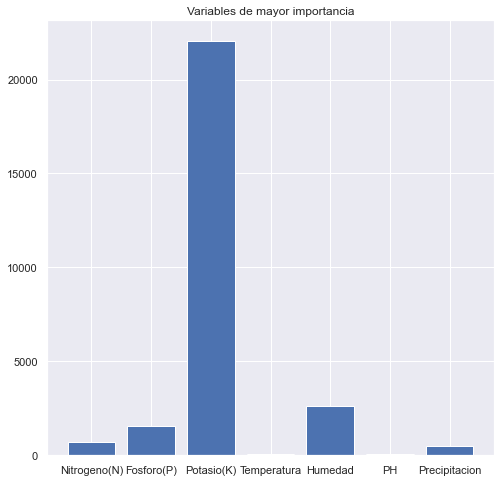

In [151]:
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X_train, y_train)
feature_names=X.columns
for i in range(len(fs.scores_)):
	print('Importance of ' +feature_names[i]+' is %f' % (fs.scores_[i]))
# plot the scores
plt.rcParams["figure.figsize"] = (8,8)
pyplot.bar([i for i in X.columns], fs.scores_)
plt.title("Variables de mayor importancia")
pyplot.show()

In [71]:
df.skew()

Nitrogeno(N)     0.509721
Fosforo(P)       1.010773
Potasio(K)       2.375167
Temperatura      0.184933
Humedad         -1.091708
PH               0.283929
Precipitacion    0.965756
dtype: float64

La función skew() devuelve un valor flotante que indica el grado de asimetría. Un valor de 0 indica que la distribución es simétrica, un valor menor que 0 indica que la distribución está sesgada negativamente, y un valor mayor que 0 indica que la distribución está sesgada positivamente.
 
Basándose en los valores de asimetría que ha proporcionado, se puede concluir que:

Nitrogeno (N): El valor de asimetría de 0,509721 indica que la distribución de los valores de Nitrógeno está ligeramente sesgada positivamente. Esto significa que los datos tienen más valores en el lado inferior de la media y menos valores en el lado superior.

Fósforo (P): El valor de asimetría de 1,010773 indica que la distribución de los valores de Fósforo está sesgada positivamente. Esto significa que los datos tienen más valores en el lado inferior de la media y menos valores en el lado superior.

Potasio (K): El valor de asimetría de 2,375167 indica que la distribución de los valores de Potasio está muy sesgada positivamente. Esto significa que los datos tienen muchos más valores en el lado inferior de la media y muy pocos valores en el lado superior.

Temperatura: El valor de asimetría de 0,177050 indica que la distribución de los valores de Temperatura es casi simétrica. Esto significa que los datos tienen un número relativamente igual de valores a ambos lados de la media.

Humedad: El valor de asimetría de -1,090947 indica que la distribución de los valores de Humedad está sesgada negativamente. Esto significa que los datos tienen más valores en el lado superior de la media y menos valores en el lado inferior.

PH: El valor de asimetría de 0,519092 indica que la distribución de los valores de PH es ligeramente asimétrica. Esto significa que los datos tienen más valores en el lado inferior de la media y menos valores en el lado superior.

Precipitación: El valor de asimetría de 0,965609 indica que la distribución de los valores de Precipitación está sesgada positivamente. Esto significa que los datos tienen más valores en el lado inferior de la media y menos valores en el lado superior.

#### Gráfico de Barras "Relación de los Macro Nutrientes en función de cada cultivo"

In [72]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=cult_resumen.index,
    y=cult_resumen['Nitrogeno(N)'],
    name='Nitrógeno',
    marker_color='lightgreen'
))
fig.add_trace(go.Bar(
    x=cult_resumen.index,
    y=cult_resumen['Fosforo(P)'],
    name='Fosforo',
    marker_color='salmon'
))
fig.add_trace(go.Bar(
    x=cult_resumen.index,
    y=cult_resumen['Potasio(K)'],
    name='Potasio',
    marker_color='lightblue'
))

fig.update_layout(title="Relación N-P-K en cada cultivo",
                  plot_bgcolor='white',
                  barmode='group',
                  xaxis_tickangle=-45)

fig.show()

- Conocer la relación entre los macro nutrientes **Nitrógeno - Fósforo - Potasio** es clave a la hora tanto de decidir que cultivo implantar como a decidir que manejo fitosanitario (fertilizaciones) se debe realizar. Esto se debe a que son nutrientes esenciales para el crecimiento de las plantas y en caso de escasez puede interferir severamente en el crecimiento, desarrollo y posterior rendimiento de los cultivos. 

## Predicciones con datos aportados por el usuario

In [163]:
## Me gustaría ingresar valores y que pueda predecir el cultivo
# Use the below code to use the model with custom values

print("Introduzca sus propios datos para probar el modelo:")
N = int(input("Introduzca el valor de Nitrógeno en Kg/ha:"))
P = int(input("Introduzca el valor de Fósforo en Kg/ha:"))
K = int(input("Introduzca el valor de Potasio en Kg/ha:"))
temp = float(input("Introduzca el valor de Temperatura en °C:"))
humidity = float(input("Introduzca el valor de Humedad en %:"))
ph = float(input("Introduzca el valor de pH en moles/L:"))
rainfall = float(input("Introduzca el valor de Precipitaciones en mm:"))


userInput = np.array([[N, P, K, temp, humidity, ph, rainfall]])


Introduzca sus propios datos para probar el modelo:
Introduzca el valor de Nitrógeno en Kg/ha:45
Introduzca el valor de Fósforo en Kg/ha:54
Introduzca el valor de Potasio en Kg/ha:34
Introduzca el valor de Temperatura en °C:34
Introduzca el valor de Humedad en %:65
Introduzca el valor de pH en moles/L:6
Introduzca el valor de Precipitaciones en mm:107


In [164]:
userInput = pd.DataFrame(userInput)
userInput.columns = ['Nitrogeno(N)', 'Fosforo(P)', 'Potasio(K)', 'Temperatura', 'Humedad', 'PH', 'Precipitacion']


In [165]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
clf = GridSearchCV(estimator = pipeline_gnb_bp, param_grid = params_gnb, cv = cv, scoring = "f1_macro")

clf.fit(X, y)

#predict target 
prediction = clf.predict(userInput)

#create dataframe with predictions
y_pred_gnb_bp = pd.DataFrame(data = prediction, columns = ["Cultivo"])

y_pred_gnb_bp

Cultivo
0  pigeonpeas

## Clustering en busca de Patrones

In [121]:
## En busca de patrones


print("Patrones de interés")


requisitos_suelo = {
"nitrógeno": (df['Nitrogeno(N)'] > 120),
"fósforo": (df['Fosforo(P)'] > 100),
"potasio": (df['Potasio(K)'] > 200),
"pH bajo": (df['PH'] < 4),
"pH alto": (df['PH'] > 9),
}

requisitos_clima = {
"precipitaciones altas": (df['Precipitacion'] > 200),
"temperatura baja": (df['Temperatura'] < 10),
"temperatura alta": (df['Temperatura'] > 40),
"humedad baja": (df['Humedad'] < 20),
}

for suelo, condicion in requisitos_suelo.items():
    cultivos = df[condicion]['Cultivo'].unique()
    if cultivos.size > 0:
        print(f"Cultivos que requieren alto contenido de {suelo} en el suelo para su desarrollo: {cultivos}")

for clima, condicion in requisitos_clima.items():
    cultivos = df[condicion]['Cultivo'].unique()
    if cultivos.size > 0:
        print(f"Cultivos que requieren {clima} para su desarrollo: {cultivos}")


Patrones de interés
Cultivos que requieren alto contenido de nitrógeno en el suelo para su desarrollo: ['cotton']
Categories (22, object): ['apple', 'banana', 'blackgram', 'chickpea', ..., 'pigeonpeas', 'pomegranate', 'rice', 'watermelon']
Cultivos que requieren alto contenido de fósforo en el suelo para su desarrollo: ['grapes', 'apple']
Categories (22, object): ['apple', 'banana', 'blackgram', 'chickpea', ..., 'pigeonpeas', 'pomegranate', 'rice', 'watermelon']
Cultivos que requieren alto contenido de potasio en el suelo para su desarrollo: ['grapes', 'apple']
Categories (22, object): ['apple', 'banana', 'blackgram', 'chickpea', ..., 'pigeonpeas', 'pomegranate', 'rice', 'watermelon']
Cultivos que requieren alto contenido de pH bajo en el suelo para su desarrollo: ['mothbeans']
Categories (22, object): ['apple', 'banana', 'blackgram', 'chickpea', ..., 'pigeonpeas', 'pomegranate', 'rice', 'watermelon']
Cultivos que requieren alto contenido de pH alto en el suelo para su desarrollo: ['mo

**Observaciones:**

- El algodón requiere una gran cantidad de nitrógeno en comparación de los otros cultivos.
- Las uvas y las manzanas requieren una cantidad muy alta de fósforo y potasio.
- Las naranjas requieren una menor cantidad de potasio para crecer
- La papaya requiere más de 30°C para su óptimo desarrollo.
- Los garbanzos y frijoles requieren poca humedad para su desarrollo.
- Todos los cultivos requieren un valor de pH de alrededor de 5 para su desarrollo.
- El arroz requiere lluvias muy intensas (más de 200 mm) para su desarrollo, no así el melón que requiere menores precipitaciones para su óptimo desarrollo. 

In [122]:
# Lets select the Spending score, and Annual Income Columns from the Data
x = df.loc[:, ['Nitrogeno(N)','Fosforo(P)','Potasio(K)','Temperatura','PH','Humedad','Precipitacion']].values

# let's check the shape of x
print(x.shape)

# lets convert this data into a dataframe
x_df  = pd.DataFrame(x)
x_df.head()

(2200, 7)


0     1     2          3         4          5           6
0  90.0  42.0  43.0  20.879744  6.502985  82.002744  202.935536
1  85.0  58.0  41.0  21.770462  7.038096  80.319644  226.655537
2  60.0  55.0  44.0  23.004459  7.840207  82.320763  263.964248
3  74.0  35.0  40.0  26.491096  6.980401  80.158363  242.864034
4  78.0  42.0  42.0  20.130175  7.628473  81.604873  262.717340

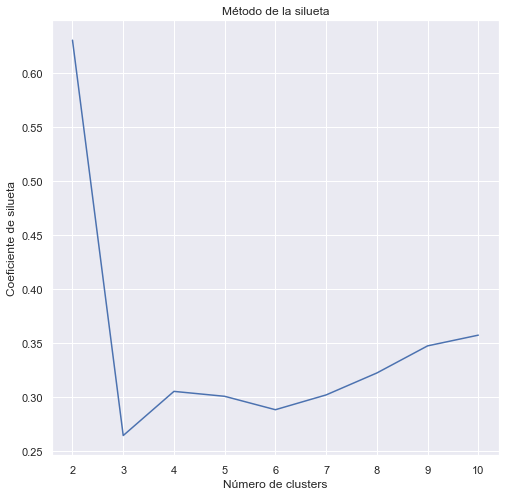

In [128]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans


# Obtener los datos preprocesados
X_preprocessed = preprocessor.fit_transform(X)

# Calcular el coeficiente de silueta para diferentes números de clusters
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_preprocessed)
    silhouette_scores.append(silhouette_score(X_preprocessed, kmeans.labels_))

# Graficar la curva de silueta
plt.plot(range(2, 11), silhouette_scores)
plt.title('Método de la silueta')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de silueta')
plt.show()


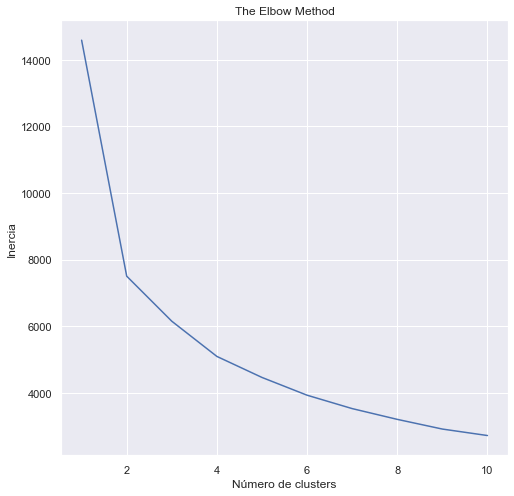

In [129]:
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_preprocessed)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias)
plt.title('The Elbow Method')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.show()

- Se puede observar que en ambos métodos el número correcto de clusters es tres (3).

In [130]:
# Obtener los datos preprocesados
X_preprocessed = preprocessor.fit_transform(X)

# Aplicar clustering con K-means
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_preprocessed)

# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocessed)

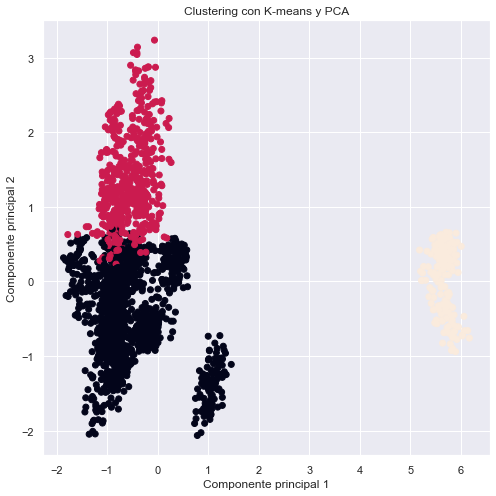

In [131]:
# Obtener los clusters
labels = kmeans.labels_

# Graficar los resultados de clustering con PCA
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Clustering con K-means y PCA')
plt.show()


In [136]:
# Crear un diccionario de cultivos para cada cluster
cluster_counts = [{} for _ in range(kmeans.n_clusters)]

for i, label in enumerate(labels):
    cultivo = df.iloc[i]['Cultivo']
    if cultivo in cluster_counts[label]:
        cluster_counts[label][cultivo] += 1
    else:
        cluster_counts[label][cultivo] = 1

# Imprimir el conteo de cultivos en cada cluster
for i, cluster in enumerate(cluster_counts):
    print(f'Cluster {i}:')
    for cultivo, count in cluster.items():
        print(f'- {cultivo}: {count}')
    print('')


Cluster 0:
- maize: 100
- chickpea: 100
- kidneybeans: 100
- pigeonpeas: 43
- mothbeans: 100
- mungbean: 100
- blackgram: 100
- lentil: 100
- pomegranate: 100
- banana: 100
- mango: 100
- watermelon: 100
- muskmelon: 100
- orange: 96
- papaya: 39
- cotton: 100
- coffee: 31

Cluster 1:
- rice: 100
- pigeonpeas: 57
- orange: 4
- papaya: 61
- coconut: 100
- jute: 100
- coffee: 69

Cluster 2:
- grapes: 100
- apple: 100



In [137]:
# Crear conjuntos de cultivos para cada cluster
cluster_0 = set()
cluster_1 = set()
cluster_2 = set()

# Iterar a través de los índices de los datos originales
for i in range(len(df)):
    label = labels[i]
    cultivo = df.iloc[i]['Cultivo']
    if label == 0:
        cluster_0.add(cultivo)
    elif label == 1:
        cluster_1.add(cultivo)
    elif label == 2:
        cluster_2.add(cultivo)
        
# Imprimir los cultivos de cada cluster
print('Cluster 0:', cluster_0)
print('Cluster 1:', cluster_1)
print('Cluster 2:', cluster_2)

Cluster 0: {'chickpea', 'blackgram', 'watermelon', 'orange', 'cotton', 'mothbeans', 'mungbean', 'banana', 'lentil', 'mango', 'pigeonpeas', 'muskmelon', 'maize', 'papaya', 'kidneybeans', 'coffee', 'pomegranate'}
Cluster 1: {'jute', 'orange', 'coconut', 'pigeonpeas', 'papaya', 'coffee', 'rice'}
Cluster 2: {'grapes', 'apple'}


In [150]:
# Acceder a los pesos de las características en los componentes principales
feature_weights = pca.components_

# Imprimir los pesos de las características en los primeros dos componentes principales
print('Pesos de las características en los componentes principales:')
print(feature_weights[:2])

Pesos de las características en los componentes principales:
[[ 0.35036745  0.92504218 -0.09009341  0.06455758 -0.08818848 -0.0311214
  -0.0225689 ]
 [-0.09064096  0.03109397  0.17671082  0.29436712 -0.31563459  0.87902265
   0.02515276]]


 - En el primer componente principal, la característica con el peso más alto es la segunda columna (fósforo), con un valor de 0.925. Esto significa que esta característica tiene una gran influencia en la dirección del primer componente principal. Las características con valores absolutos más bajos en el primer componente principal son la sexta (pH) y la séptima columnas (precipitaciones), con valores de 0.031 y 0.023, respectivamente. Esto indica que estas características tienen una influencia menor en la dirección del primer componente principal.

- De manera similar, en el segundo componente principal, la característica con el peso más alto es la sexta columna (pH), con un valor de 0.879. Esto significa que esta característica tiene una gran influencia en la dirección del segundo componente principal. Las características con valores absolutos más bajos en el segundo componente principal son la primera (nitrógeno) y la cuarta columna (temperatura), con valores de 0.091 y 0.294, respectivamente.

#### Box Plot de cada columna en función de los Clusters

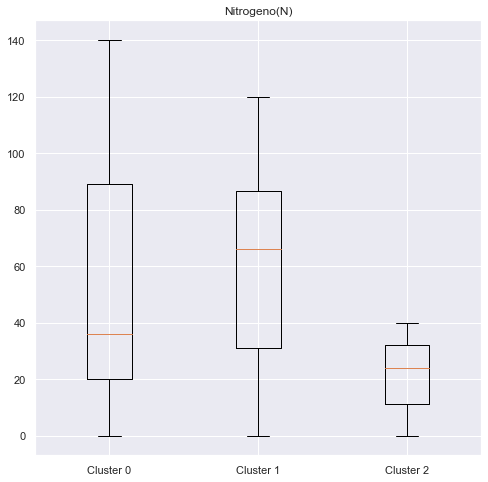

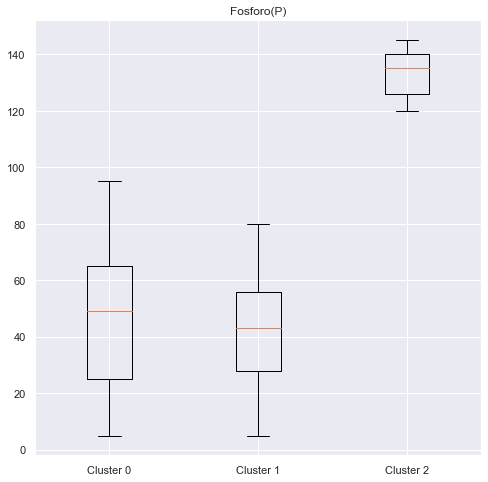

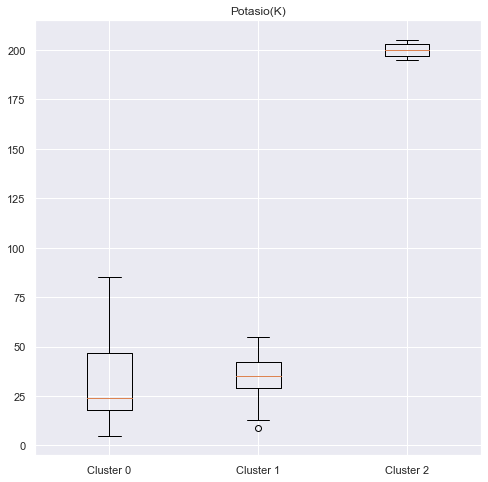

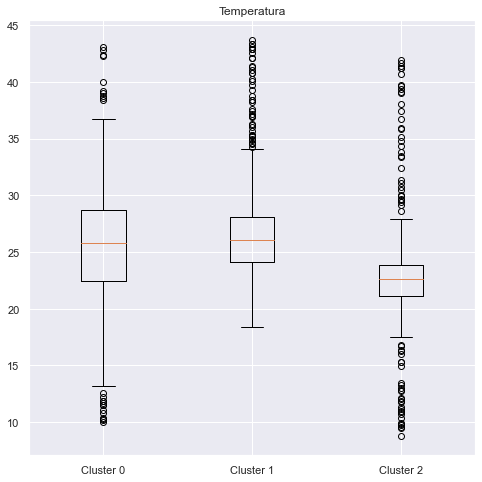

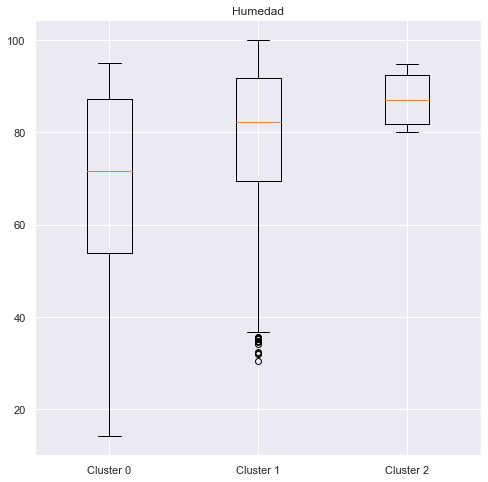

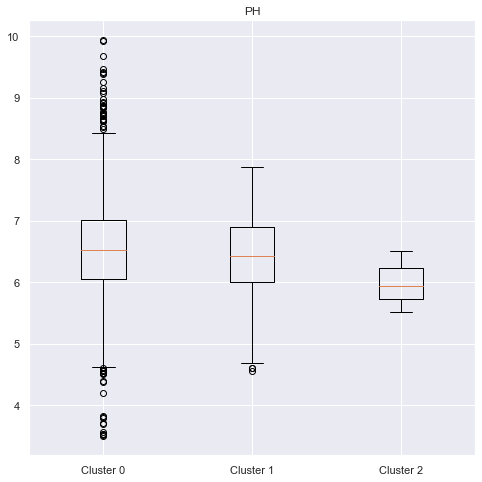

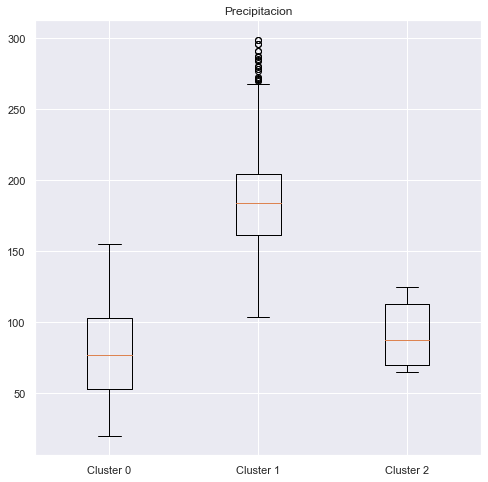

In [146]:
for column in X:
    plt.boxplot([X[column][labels==0], X[column][labels==1], X[column][labels==2]], labels=['Cluster 0', 'Cluster 1', 'Cluster 2'])
    plt.title(column)
    plt.show()
    

In [138]:
#!pip install matplotlib_venn

#### Diagrama de Venn

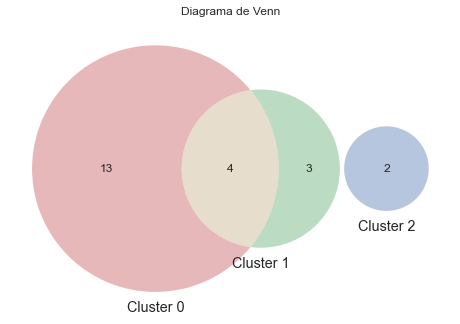

In [204]:
from matplotlib_venn import venn3

# Crear el diagrama de Venn
venn3([cluster_0, cluster_1, cluster_2], ('Cluster 0', 'Cluster 1', 'Cluster 2'))
plt.title('Diagrama de Venn')
# Mostrar el diagrama
plt.show()


- Se puede observar que hay 4 clases que pertenecen tanto al cluster 0 como al cluster 1.
- Esto puede ser interesante para futuras investigaciones o prácticas agrícolas, ya que al encontrar patrones se podrían observar similitudes de utilidad a la hora de la siembra, el manejo general del cultivo y la cosecha, por ejemplo.
- Además, al saber que ciertos cultivos se agrupan juntos, los agricultores y los productores pueden optimizar su producción y el manejo de sus cultivos para maximizar su rendimiento.

#### Parallel Coordinates Plot por Cluster

In [201]:
df_cluster0 =  df[df['Cultivo'].isin(['maize', 'kidneybeans', 'chickpea', 'mungbean', 'blackgram', 'pigeonpeas', 'coffee', 'mothbeans', 'muskmelon', 'papaya', 'pomegranate', 'banana', 'mango', 'lentil', 'orange', 'cotton', 'watermelon' 'mothbeans'])]

In [227]:
df_c0 = df_cluster0
plot_parallel_coordinates(df_c0, 'Distribución de características de los cultivos de cluster 0 ')

In [203]:
df_cluster1 =  df[df['Cultivo'].isin(['rice', 'coffee', 'pigeonpeas', 'jute', 'coconut', 'papaya''kidneybeans', 'pigeonpeas', 'coffee', 'papaya', 'coconut', 'jute', 'rice'])]

In [228]:
df_c1 = df_cluster1
plot_parallel_coordinates(df_c1, 'Distribución de características de los cultivos de cluster 1')

In [206]:
df_cluster2 =  df[df['Cultivo'].isin(['apple', 'grapes'])]

In [229]:
df_c2 = df_cluster2
plot_parallel_coordinates(df_c2, 'Distribución de características de los cultivos de cluster 2')

## Conclusiones

- Sobre un Data Set con 2200 muestras de factores medioambientales y físico-químico de 22 clases distintas de cultivos, se ha realizado un análisis de la información, por un lado, y se han aplicado modelos predictivos supervisados (Clasificación Multiclase) y no supervisado (Clustering) por el otro, para predecir si en función de las variables dadas podría saberse cuál es el cultivo más idóneo para implantar en determinada región.
- El objetivo principal del trabajo es obtener el mayor porcentaje de precisión posible, medibles con los puntajes de **accuracy, F1 Score** (ambas considerando porcentaje de aciertos) y **Cross Validation** (que hace un análisis similar, pero, probando no uno sino diferentes particiones de los datos entre entrenamiento y prueba). 
- Se ha probado con diferentes modelos predictivos de la librería **Scikit-Learn**, aplicando pipeline y luego se han medido sus resultados. Los mejores resultados se obtuvieron con los modelos **GaussianNB** y **RandomForestClassifier**. Ambos arrojaron, un accuracy del 100%. 
- Luego para optimizar los resultados de los modelos **GaussianNB**, **RandomForestClassifier** y **GradientBoostingClassifier** se trabajó, primero mejorando los parámetros del modelo, con el paquete **GridSearchCV**, de la librería ya mencionada, y **RepeatedStratifiedKFold** que es una técnica de validación cruzada que combina la estratificación y la repetición de los datos para obtener una estimación más precisa y robusta del rendimiento del modelo. Mediante estos procesos no se obtuvieron cambios muy significativos ya que los valores de F1 eran muy cercanos a uno (1). 
- También se realizó búsqueda de patrones utilizando modelos predictivos no supervisados (Clustering). Aplicando el **Método de la Silueta y del Codo**, se obtuvo que el número de clusters correcto es igual a tres (3).
- En el **primer componente principal**, la característica con el peso más alto es la **segunda columna** que corresponde al **Fósforo** y en el **segundo componente principal** es la **sexta columna** que corresponde al **pH**.
- Esto puede ser interesante para futuras investigaciones o prácticas agrícolas, ya que al encontrar patrones se podrían observar similitudes de utilidad a la hora de la siembra, el manejo general del cultivo y la cosecha, por ejemplo. 
- En síntesis, los mejores modelos **GaussianNB y RandomForestClassifier arrojaron una precisión del 100% con un recall (posibilidad de no arrojar falsos negativos) para la mayoría de las clases del 100%**. 
- Se sugiere continuar con la investigación buscando nuevas características que aporten valor a la misma y sean de utilidad práctica para los agricultores y los productores buscando optimizar su producción y el manejo de sus cultivos para maximizar su rendimiento.
